# MODELLING

**Clarify Objective:**

Goal is to predict death

In [85]:
import xgboost
import sklearn
print(f"xgboost version: {xgboost.__version__}")
print(f"scikit-learn version: {sklearn.__version__}") # xgboost error with higher version of scikit-learn SHOULD BE 1.3.1 OR LOWER

xgboost version: 2.1.3
scikit-learn version: 1.6.1


In [86]:
# %pip uninstall scikit-learn
# %pip install scikit-learn==1.6.1

In [87]:
# Install required packages (uncomment if not already installed)
#%pip install pandas numpy matplotlib seaborn scipy scikit-learn
#%pip uninstall sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import pointbiserialr
import sklearn
import xgboost

import os

In [88]:
# Check the current working directory
# print("Current Working Directory:", os.getcwd())

df = pd.read_csv('../data/processed/df.csv')
df_clean = pd.read_csv('../data/processed/df_clean.csv')


In [89]:
df.isnull().sum()

adlp        6254
adls        3184
adlsc          0
age            0
alb         3744
aps            1
avtisst       91
bili        2871
bun         4849
ca             0
charges      198
crea          75
death          0
dementia       0
diabetes       0
dnr           32
dnrday        32
dzclass        0
dzgroup        0
edu         1809
feat01         0
feat02         0
feat03         0
feat04         0
feat05         0
feat06         0
feat07         0
feat08         0
feat09         0
feat10         0
glucose     5016
hday           0
hospdead       0
hrt            1
income      3291
meanbp         0
num.co         0
pafi        2618
ph          2574
prg2m       1837
prg6m       1820
race          49
resp           1
scoma          1
sex            0
sfdm2       1564
sod            1
sps            1
surv2m         1
surv6m         1
temp           1
totcst       994
totmcst     3880
urine       5411
wblc         243
dtype: int64

In [90]:
df_clean.isnull().sum()

adlsc                    0
age                      0
aps                      0
avtisst                  0
ca                       0
                        ..
scoma_sps_interaction    0
sfdm2_imputed            0
glucose_imputed          0
glucose_category         0
num_co_binary            0
Length: 69, dtype: int64

In [91]:
from sklearn.linear_model import LogisticRegression
print("scikit-learn is installed and working properly")


scikit-learn is installed and working properly


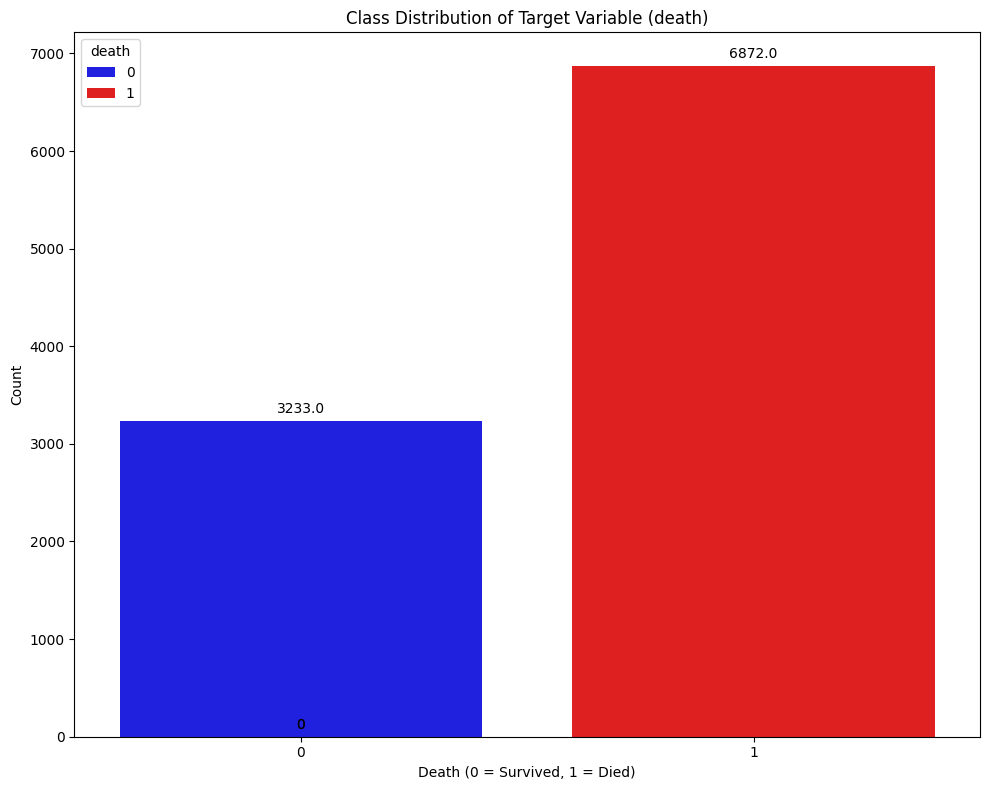

In [92]:
# Visualize class imbalance for the 'death' variable in df_clean
plt.figure(figsize=(10, 8))
sns.countplot(x=df_clean['death'], palette=["blue", "red"], hue=df_clean['death'])  # Set colors to blue and red
plt.title("Class Distribution of Target Variable (death)")
plt.xlabel("Death (0 = Survived, 1 = Died)")
plt.ylabel("Count")
for p in plt.gca().patches:
    plt.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + 50,
        f'{p.get_height()}',
        ha='center',
        va='bottom'
    )
plt.tight_layout()
plt.savefig("class_distribution_classification_colored.png", dpi=300)
plt.show()

Class inbalance is present, need to be carefull

## 0.1. Define the `target variable` and `features` + `encoding categorical` + `train-test split` + `encoding categorical`

In [93]:
# Re-import necessary libraries after execution state reset
import pandas as pd

# Define the first table: Encoding and Scaling Approaches
encoding_scaling_table = pd.DataFrame({
    "Transformation": ["No Scaling", "StandardScaler", "OneHot Encoding", "Label Encoding", "Target/Mean Encoding"],
    "Use for Models": [
        "Tree-based models (XGBoost, Random Forest, Decision Trees) handle raw numeric data well.",
        "Logistic Regression, Neural Networks (MLP, CNN, RNN) for better convergence.",
        "Works well for linear models & neural networks.",
        "Preferred for tree-based models (XGBoost, RandomForest).",
        "For high-cardinality categorical variables."
    ]
})

# Print the tables as markdown for better readability
print("\n=== Encoding & Scaling Approaches ===")
print(encoding_scaling_table.to_markdown(index=False))


=== Encoding & Scaling Approaches ===
| Transformation       | Use for Models                                                                           |
|:---------------------|:-----------------------------------------------------------------------------------------|
| No Scaling           | Tree-based models (XGBoost, Random Forest, Decision Trees) handle raw numeric data well. |
| StandardScaler       | Logistic Regression, Neural Networks (MLP, CNN, RNN) for better convergence.             |
| OneHot Encoding      | Works well for linear models & neural networks.                                          |
| Label Encoding       | Preferred for tree-based models (XGBoost, RandomForest).                                 |
| Target/Mean Encoding | For high-cardinality categorical variables.                                              |


In [166]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix, roc_curve,
    precision_score, recall_score, f1_score, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [167]:
# Separate Features & Target for Both Versions
X_clean = df_clean.drop(columns=['death'])  # Clean dataset
y_clean = df_clean['death']

X_raw = df.drop(columns=['death'])  # Raw dataset (before cleaning)
y_raw = df['death']

# Split Data (Train-Test)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw
)

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

# Identify categorical & numerical columns
cat_cols_clean = X_clean.select_dtypes(include=['object']).columns.tolist()
num_cols_clean = X_clean.select_dtypes(include=[np.number]).columns.tolist()

cat_cols_raw = X_raw.select_dtypes(include=['object']).columns.tolist()
num_cols_raw = X_raw.select_dtypes(include=[np.number]).columns.tolist()

In [168]:
import pandas as pd

# Function to check cardinality
def check_cardinality(df, categorical_cols, threshold=6): # threshold here is subjective, i though 6 is a good number, that' why i went with it, but i may use mean encoding for like most variables later on, we will see
    """
    Prints cardinality of categorical features and suggests encoding techniques.
    
    Parameters:
    - df: DataFrame
    - categorical_cols: List of categorical columns
    - threshold: Maximum unique values allowed for One-Hot Encoding (default=10)
    """
    cardinality_dict = {col: df[col].nunique() for col in categorical_cols}
    cardinality_df = pd.DataFrame(list(cardinality_dict.items()), columns=['Feature', 'Unique Values'])
    
    # Suggest encoding methods
    cardinality_df['Suggested Encoding'] = cardinality_df['Unique Values'].apply(
        lambda x: 'One-Hot Encoding' if x <= threshold else 'Target Encoding (Mean Encoding)'
    )
    
    print("\n=== Cardinality Check for Categorical Features ===")
    print(cardinality_df.to_string(index=False))

    return cardinality_df

# Run cardinality check on both raw and clean datasets
cat_cardinality_raw = check_cardinality(df, cat_cols_raw)
cat_cardinality_clean = check_cardinality(df_clean, cat_cols_clean)



=== Cardinality Check for Categorical Features ===
Feature  Unique Values              Suggested Encoding
     ca              3                One-Hot Encoding
    dnr              3                One-Hot Encoding
dzclass              4                One-Hot Encoding
dzgroup              8 Target Encoding (Mean Encoding)
 income              4                One-Hot Encoding
   race              5                One-Hot Encoding
    sex              2                One-Hot Encoding
  sfdm2              5                One-Hot Encoding

=== Cardinality Check for Categorical Features ===
         Feature  Unique Values              Suggested Encoding
              ca              3                One-Hot Encoding
             dnr              4                One-Hot Encoding
         dzclass              4                One-Hot Encoding
         dzgroup              8 Target Encoding (Mean Encoding)
          income              4                One-Hot Encoding
            race 

In [169]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder

# Find high-cardinality categorical features
high_cardinality_cols_clean = cat_cardinality_clean[cat_cardinality_clean["Suggested Encoding"] == "Target Encoding (Mean Encoding)"]["Feature"].tolist()
high_cardinality_cols_raw = cat_cardinality_raw[cat_cardinality_raw["Suggested Encoding"] == "Target Encoding (Mean Encoding)"]["Feature"].tolist()

# One-Hot Encode low-cardinality features
low_cardinality_cols_clean = list(set(cat_cols_clean) - set(high_cardinality_cols_clean))
low_cardinality_cols_raw = list(set(cat_cols_raw) - set(high_cardinality_cols_raw))

# Define Updated Preprocessing Pipelines
# Logistic Regression & Neural Networks (Scaling + Mixed Encoding)
ct_clean_logit_nn = ColumnTransformer([
    ("scale_num", StandardScaler(), num_cols_clean),
    ("onehot_cat", OneHotEncoder(drop='first', handle_unknown='ignore'), low_cardinality_cols_clean),
    ("target_cat", TargetEncoder(cols=high_cardinality_cols_clean), high_cardinality_cols_clean)
])

ct_raw_logit_nn = ColumnTransformer([
    ("scale_num", StandardScaler(), num_cols_raw),
    ("onehot_cat", OneHotEncoder(drop='first', handle_unknown='ignore'), low_cardinality_cols_raw),
    ("target_cat", TargetEncoder(cols=high_cardinality_cols_raw), high_cardinality_cols_raw)
])

print("Done logit_nn transformers")



# Tree-Based Models (Random Forest, XGBoost) -> **Label Encoding**
X_train_clean_tree, X_test_clean_tree = X_train_clean.copy(), X_test_clean.copy()
X_train_raw_tree, X_test_raw_tree = X_train_raw.copy(), X_test_raw.copy()

for col in cat_cols_clean:
    le = LabelEncoder()
    X_train_clean_tree[col] = le.fit_transform(X_train_clean_tree[col])
    X_test_clean_tree[col] = le.transform(X_test_clean_tree[col])

for col in cat_cols_raw:
    le = LabelEncoder()
    X_train_raw_tree[col] = le.fit_transform(X_train_raw_tree[col])
    X_test_raw_tree[col] = le.transform(X_test_raw_tree[col])

print("Done tree transformers")



# XGBoost (Alternative with Target Encoding for High-Cardinality)
te_clean = TargetEncoder(cols=cat_cols_clean) #high_cardinality_cols_clean
X_train_clean_mean = te_clean.fit_transform(X_train_clean, y_train_clean)
X_test_clean_mean = te_clean.transform(X_test_clean)

te_raw = TargetEncoder(cols=cat_cols_raw) #high_cardinality_cols_clean
X_train_raw_mean = te_raw.fit_transform(X_train_raw, y_train_raw)
X_test_raw_mean = te_raw.transform(X_test_raw)

print("Done XGBoost transformers")

Done logit_nn transformers
Done tree transformers
Done XGBoost transformers


In [170]:
import pandas as pd

# Define Model to Feature Set & Preprocessing Pipeline Mapping
model_feature_pipeline_table = pd.DataFrame({
    "Model": [
        "Logistic Regression & Neural Networks",
        "RandomForest / XGBoost / Decision Trees",
        "XGBoost (Alternative with Target Encoding)"
    ],
    "Clean Feature Set": [
        "X_train_clean_logit_nn, X_test_clean_logit_nn",
        "X_train_clean_tree, X_test_clean_tree",
        "X_train_clean_mean, X_test_clean_mean"
    ],
    "Raw Feature Set": [
        "X_train_raw_logit_nn, X_test_raw_logit_nn",
        "X_train_raw_tree, X_test_raw_tree",
        "X_train_raw_mean, X_test_raw_mean"
    ],
    "Preprocessing Pipeline": [
        "ct_clean_logit_nn, ct_raw_logit_nn",
        "Label Encoding (Manual Transformation)",
        "Target Encoding (TargetEncoder)"
    ]
})

# Print the formatted table
print("\n=== Model to Feature Set & Preprocessing Pipeline Mapping ===")
print(model_feature_pipeline_table.to_markdown(index=False))


=== Model to Feature Set & Preprocessing Pipeline Mapping ===
| Model                                      | Clean Feature Set                             | Raw Feature Set                           | Preprocessing Pipeline                 |
|:-------------------------------------------|:----------------------------------------------|:------------------------------------------|:---------------------------------------|
| Logistic Regression & Neural Networks      | X_train_clean_logit_nn, X_test_clean_logit_nn | X_train_raw_logit_nn, X_test_raw_logit_nn | ct_clean_logit_nn, ct_raw_logit_nn     |
| RandomForest / XGBoost / Decision Trees    | X_train_clean_tree, X_test_clean_tree         | X_train_raw_tree, X_test_raw_tree         | Label Encoding (Manual Transformation) |
| XGBoost (Alternative with Target Encoding) | X_train_clean_mean, X_test_clean_mean         | X_train_raw_mean, X_test_raw_mean         | Target Encoding (TargetEncoder)        |


In [171]:
# path for future savings of visualizations
output_dir = "../visualizations"
os.makedirs(output_dir, exist_ok=True)

## 0.2. FUNCTIONS

In [172]:
# def evaluate_model(model, X_test, y_test, model_name):
#     y_pred = model.predict(X_test)
#     y_pred_prob = model.predict_proba(X_test)[:, 1]

#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     roc_auc = roc_auc_score(y_test, y_pred_prob)

#     print(f"\n=== {model_name} Performance ===")
#     print(f"Accuracy:  {accuracy:.3f}")
#     print(f"Precision: {precision:.3f}")
#     print(f"Recall:    {recall:.3f}")
#     print(f"F1-Score:  {f1:.3f}")
#     print(f"ROC-AUC:   {roc_auc:.4f}")

#     cm = confusion_matrix(y_test, y_pred)
#     print("\n=== Confusion Matrix ===")
#     print(cm)

#     return accuracy, precision, recall, f1, roc_auc, cm, y_pred_prob

In [173]:
# import os
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from sklearn.metrics import roc_curve

# def evaluate_and_plot_model(results, output_dir="../visualizations", prefix="logit"):
#     """
#     Evaluates models and generates plots for:
#     - ROC Curve
#     - Confusion Matrix
#     - Performance Metrics Bar Chart

#     Args:
#         results (dict): Model results containing (accuracy, precision, recall, f1, roc_auc, cm, y_pred_prob).
#         output_dir (str): Path where the evaluation plots will be saved.
#         prefix (str): Prefix to use for saving files (e.g., "logit", "xgb", "rf").
#     """

#     # Ensure output directory exists
#     os.makedirs(output_dir, exist_ok=True)

#     # Iterate through stored results and plot
#     for model_name, (accuracy, precision, recall, f1, roc_auc, cm, y_pred_prob) in results.items():
#         # Format Model Name for File Naming
#         model_name_clean = model_name.replace(" ", "_").lower()

#         # **Create a Single Figure with 3 Subplots**
#         fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#         # **Plot ROC Curve**
#         fpr, tpr, _ = roc_curve(y_test_clean, y_pred_prob)
#         axes[0].plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})', color='blue')
#         axes[0].plot([0, 1], [0, 1], linestyle="--", color="black")  # Fixed redundant definition
#         axes[0].set_xlabel("False Positive Rate")
#         axes[0].set_ylabel("True Positive Rate")
#         axes[0].set_title(f"ROC Curve - {model_name}")
#         axes[0].legend(loc="lower right")

#         # **Plot Confusion Matrix**
#         sns.heatmap(
#             cm, 
#             annot=True, 
#             cmap="Blues", 
#             fmt="d",
#             xticklabels=["Survived (0)", "Died (1)"], 
#             yticklabels=["Survived (0)", "Died (1)"],
#             ax=axes[1]
#         )
#         axes[1].set_title(f"Confusion Matrix - {model_name}")
#         axes[1].set_ylabel("True Label")
#         axes[1].set_xlabel("Predicted Label")

#         # **Plot Bar Chart for Model Metrics**
#         metric_names = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
#         metric_values = [accuracy, precision, recall, f1, roc_auc]

#         barplot = sns.barplot(x=metric_names, y=metric_values, ax=axes[2], palette="coolwarm", edgecolor="black", legend=False, hue = metric_names)
#         axes[2].set_ylim(0, 1)  # Metrics range from 0 to 1
#         axes[2].set_title(f"Performance Metrics - {model_name}")
#         axes[2].set_ylabel("Score")

#         # **Fix set_ticklabels() issue by explicitly setting ticks**
#         axes[2].set_xticks(range(len(metric_names)))
#         axes[2].set_xticklabels(metric_names, rotation=45, ha="right")

#         # **Add Values on Bars**
#         for bar in barplot.patches:
#             axes[2].text(
#                 bar.get_x() + bar.get_width() / 2,
#                 bar.get_height(),
#                 f"{bar.get_height():.3f}", 
#                 ha='center', va='bottom', fontsize=10, fontweight="bold", color="black"
#             )

#         # **Save the Figure**
#         eval_plot_path = os.path.join(output_dir, f"{prefix}_{model_name_clean}_evaluation.png")
#         plt.tight_layout()
#         plt.savefig(eval_plot_path, dpi=300)
#         plt.show()

#         print(f"Evaluation plot saved to: {eval_plot_path}")


In [174]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, balanced_accuracy_score, fbeta_score

def evaluate_model_extended(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    gini = 2 * roc_auc - 1  # Gini Coefficient
    mcc = matthews_corrcoef(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)  # F2-score

    print(f"\n=== {model_name} Performance ===")
    print(f"Accuracy:         {accuracy:.3f}")
    print(f"Precision:        {precision:.3f}")
    print(f"Recall:           {recall:.3f}")
    print(f"F1-Score:         {f1:.3f}")
    print(f"F2-Score:         {f2:.3f}")
    print(f"ROC-AUC:          {roc_auc:.4f}")
    print(f"Gini Coefficient: {gini:.4f}")
    print(f"MCC:              {mcc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    return accuracy, precision, recall, f1, f2, roc_auc, gini, mcc, balanced_acc, y_pred_prob


In [175]:
def evaluate_and_plot_model_extended(results, y_test, output_dir="../visualizations", prefix="logit"):
    """
    Evaluates models and generates plots for:
    - ROC Curve
    - Confusion Matrix
    - Performance Metrics Bar Chart (including new metrics: Gini, MCC, Balanced Accuracy, F2-Score)

    Args:
        results (dict): Model results containing (accuracy, precision, recall, f1, roc_auc, gini, mcc, balanced_acc, f2, cm, y_pred_prob).
        y_test (array-like): True labels for test set.
        output_dir (str): Path where the evaluation plots will be saved.
        prefix (str): Prefix to use for saving files (e.g., "logit", "xgb", "rf").
    """

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Iterate through stored results and plot
    for model_name, (accuracy, precision, recall, f1, roc_auc, gini, mcc, balanced_acc, f2, cm, y_pred_prob) in results.items():
        # Format Model Name for File Naming
        model_name_clean = model_name.replace(" ", "_").lower()

        # Compute additional metrics
        y_pred = (y_pred_prob >= 0.5).astype(int)  # Convert probabilities to binary predictions

        # Create a Single Figure with 4 Subplots
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # **Plot ROC Curve**
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        axes[0, 0].plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})', color='blue')
        axes[0, 0].plot([0, 1], [0, 1], linestyle="--", color="black")  # Fixed redundant definition
        axes[0, 0].set_xlabel("False Positive Rate")
        axes[0, 0].set_ylabel("True Positive Rate")
        axes[0, 0].set_title(f"ROC Curve - {model_name}")
        axes[0, 0].legend(loc="lower right")

        # **Plot Confusion Matrix**
        sns.heatmap(
            cm, 
            annot=True, 
            cmap="Blues", 
            fmt="d",
            xticklabels=["Survived (0)", "Died (1)"], 
            yticklabels=["Survived (0)", "Died (1)"],
            ax=axes[0, 1]
        )
        axes[0, 1].set_title(f"Confusion Matrix - {model_name}")
        axes[0, 1].set_ylabel("True Label")
        axes[0, 1].set_xlabel("Predicted Label")

        # **Plot Bar Chart for Model Metrics**
        metric_names = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini", "MCC", "Balanced Acc", "F2-Score"]
        metric_values = [accuracy, precision, recall, f1, roc_auc, gini, mcc, balanced_acc, f2]

        barplot = sns.barplot(x=metric_names, y=metric_values, ax=axes[1, 0], palette="coolwarm", edgecolor="black", hue=metric_names)
        axes[1, 0].set_ylim(0, 1)  # Metrics range from 0 to 1
        axes[1, 0].set_title(f"Performance Metrics - {model_name}")
        axes[1, 0].set_ylabel("Score")

        # **Fix set_ticklabels() issue by explicitly setting ticks**
        axes[1, 0].set_xticks(range(len(metric_names)))
        axes[1, 0].set_xticklabels(metric_names, rotation=45, ha="right")

        # **Add Values on Bars**
        for bar in barplot.patches:
            axes[1, 0].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{bar.get_height():.3f}", 
                ha='center', va='bottom', fontsize=10, fontweight="bold", color="black"
            )

        # **Plot Gini Coefficient Separately**
        axes[1, 1].bar(["Gini Coefficient"], [gini], color='purple', edgecolor="black")
        axes[1, 1].set_ylim(0, 1)
        axes[1, 1].set_title("Gini Coefficient")
        axes[1, 1].set_ylabel("Score")
        axes[1, 1].text(0, gini, f"{gini:.3f}", ha='center', va='bottom', fontsize=10, fontweight="bold", color="black")

        # **Save the Figure**
        eval_plot_path = os.path.join(output_dir, f"{prefix}_{model_name_clean}_evaluation.png")
        plt.tight_layout()
        plt.savefig(eval_plot_path, dpi=300)
        plt.show()

        print(f"Evaluation plot saved to: {eval_plot_path}")


## 1. Baseline Models (LOGIT)

In [176]:
# Create a pipeline for Logistic Regression (Base Model)
logit_pipeline = Pipeline([
    ("preprocessor", ct_clean_logit_nn),
    ("logreg", LogisticRegression(random_state=420, max_iter=1000))
])

# Train Model
logit_pipeline.fit(X_train_clean, y_train_clean)

# Predictions
y_pred = logit_pipeline.predict(X_test_clean)
y_pred_prob = logit_pipeline.predict_proba(X_test_clean)[:, 1]

In [177]:
# Create a pipeline with class weight balancing
logit_pipeline_balanced = Pipeline([
    ("preprocessor", ct_clean_logit_nn),
    ("logreg", LogisticRegression(random_state=420, max_iter=1000, class_weight='balanced'))
])

# Train Model
logit_pipeline_balanced.fit(X_train_clean, y_train_clean)

# Predictions
y_pred_balanced = logit_pipeline_balanced.predict(X_test_clean)
y_pred_prob_balanced = logit_pipeline_balanced.predict_proba(X_test_clean)[:, 1]


In [178]:
# Create a pipeline with SMOTE for oversampling
logit_pipeline_smote = ImbPipeline([
    ("preprocessor", ct_clean_logit_nn),
    ("smote", SMOTE(random_state=42)),
    ("logreg", LogisticRegression(random_state=420, max_iter=1000))
])

# Train Model
logit_pipeline_smote.fit(X_train_clean, y_train_clean)

# Predictions
y_pred_smote = logit_pipeline_smote.predict(X_test_clean)
y_pred_prob_smote = logit_pipeline_smote.predict_proba(X_test_clean)[:, 1]


Perform a grid search to find the best hyperparameters for a logistic regression model using SMOTE for handling class imbalance.

Parameters:
- param_grid (dict): Dictionary with parameters names (`str`) as keys and lists of parameter settings to try as values. 
    - "logreg__C": List of regularization strengths to try for the logistic regression model.
    - "logreg__penalty": List of penalty terms to use for the logistic regression model. In this case, only "l2" is used.
    - "logreg__solver": List of solvers to use for the logistic regression model.

- grid_search (GridSearchCV): GridSearchCV object to perform the grid search.
    - logit_pipeline_smote: Pipeline object that includes the logistic regression model and SMOTE for handling class imbalance.
    - scoring (str): Scoring metric to evaluate the models. In this case, "roc_auc" is used.
    - cv (int): Number of cross-validation folds.
    - verbose (int): Verbosity level.
    - n_jobs (int): Number of jobs to run in parallel. -1 means using all processors.

In [179]:
param_grid = {
    "logreg__C": [0.1, 0.5, 1, 5, 7, 9, 10],
    "logreg__penalty": ["l2"],
    "logreg__solver": ["lbfgs", "liblinear"]
}

grid_search = GridSearchCV(
    logit_pipeline_smote, param_grid, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1
)

# Train the model using GridSearch
grid_search.fit(X_train_clean, y_train_clean)

# Extract the best model
best_model = grid_search.best_estimator_

# Save best hyperparameters
best_params = grid_search.best_params_

# Print best parameters
print("\n=== Best Hyperparameters from GridSearch ===")
for key, value in best_params.items():
    print(f"{key}: {value}")

Fitting 5 folds for each of 14 candidates, totalling 70 fits

=== Best Hyperparameters from GridSearch ===
logreg__C: 5
logreg__penalty: l2
logreg__solver: liblinear


In [180]:
results_logit = {}
for name, model in {
    "Base Logistic Regression": logit_pipeline,
    "Balanced Logistic Regression": logit_pipeline_balanced,
    "SMOTE Logistic Regression": logit_pipeline_smote,
    "Best Tuned Model (GridSearch)": best_model
}.items():
    y_pred = model.predict(X_test_clean)
    y_pred_prob = model.predict_proba(X_test_clean)[:, 1]

    accuracy = accuracy_score(y_test_clean, y_pred)
    precision = precision_score(y_test_clean, y_pred)
    recall = recall_score(y_test_clean, y_pred)
    f1 = f1_score(y_test_clean, y_pred)
    roc_auc = roc_auc_score(y_test_clean, y_pred_prob)
    cm = confusion_matrix(y_test_clean, y_pred)

    # New Metrics
    gini = 2 * roc_auc - 1
    mcc = matthews_corrcoef(y_test_clean, y_pred)
    balanced_acc = balanced_accuracy_score(y_test_clean, y_pred)
    f2 = fbeta_score(y_test_clean, y_pred, beta=2)

    results_logit[name] = (accuracy, precision, recall, f1, roc_auc, gini, mcc, balanced_acc, f2, cm, y_pred_prob)


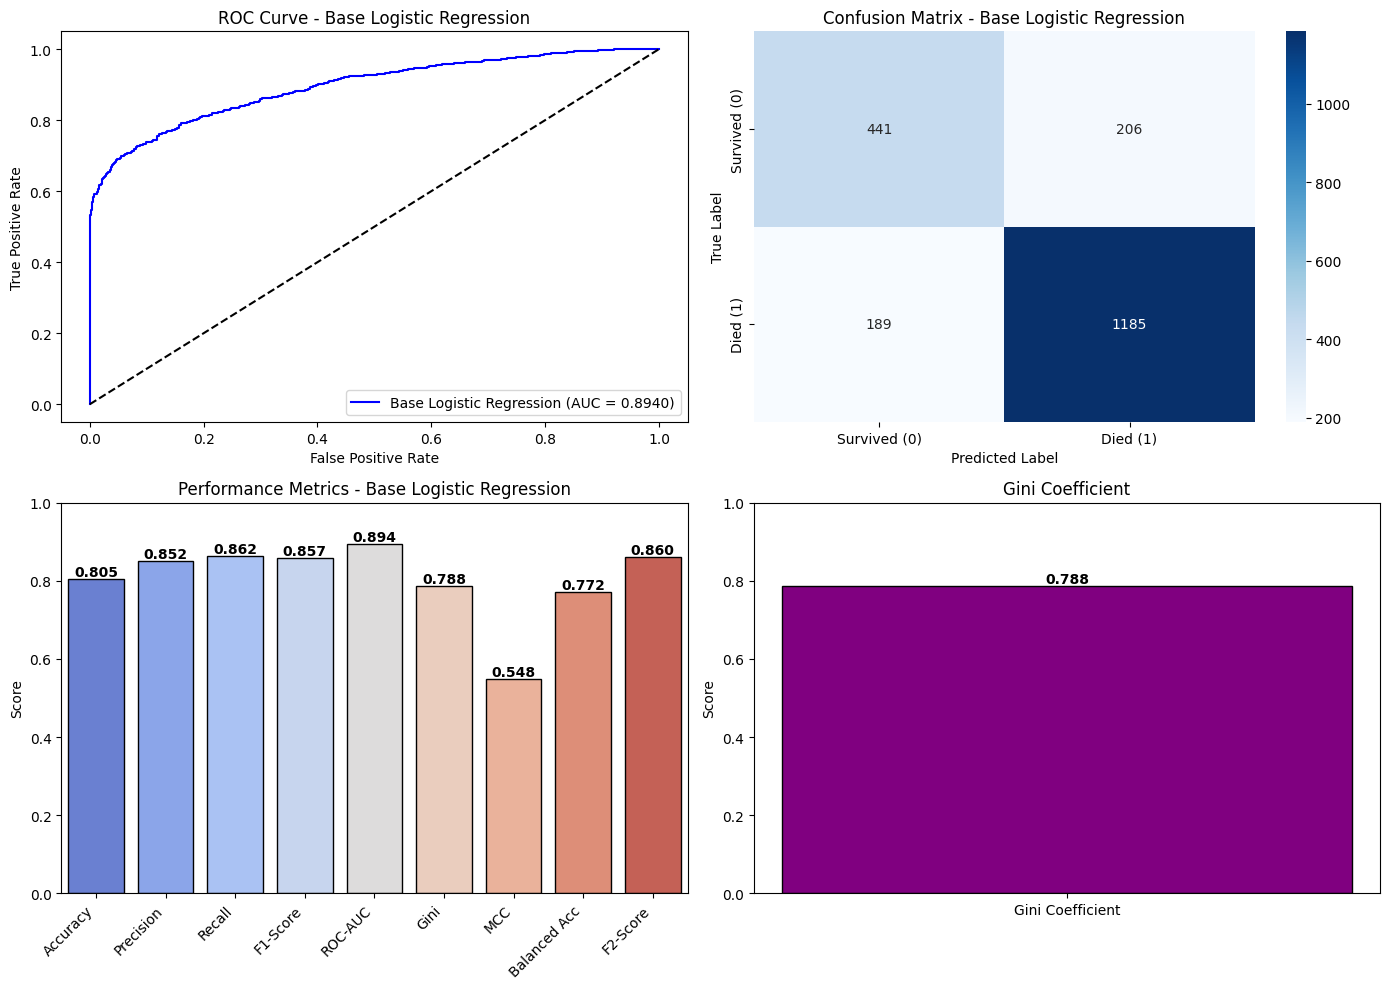

Evaluation plot saved to: ../visualizations\logit_base_logistic_regression_evaluation.png


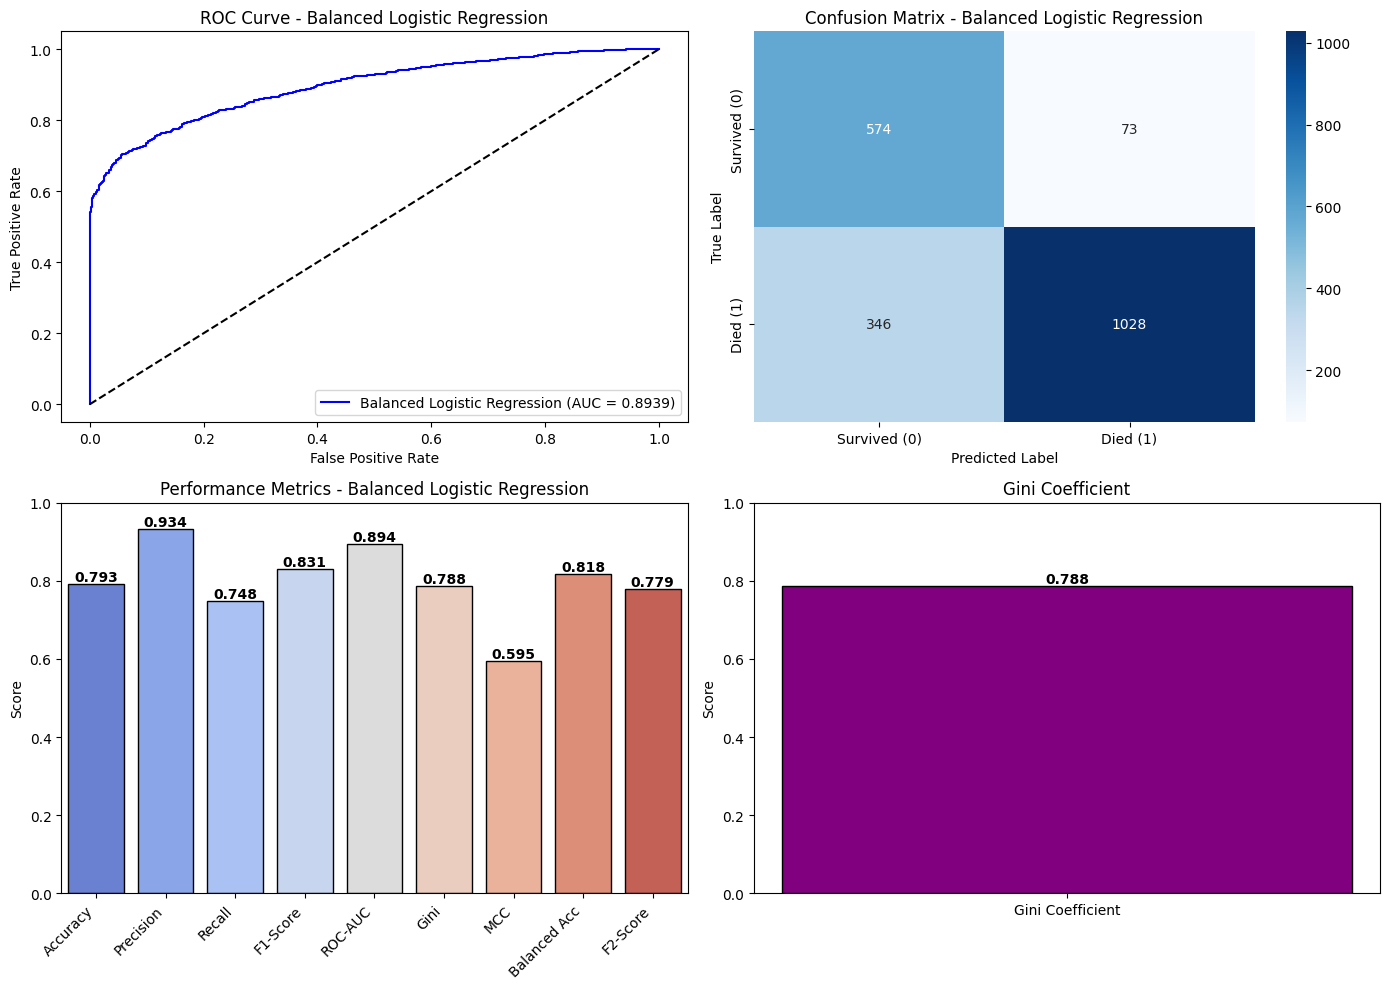

Evaluation plot saved to: ../visualizations\logit_balanced_logistic_regression_evaluation.png


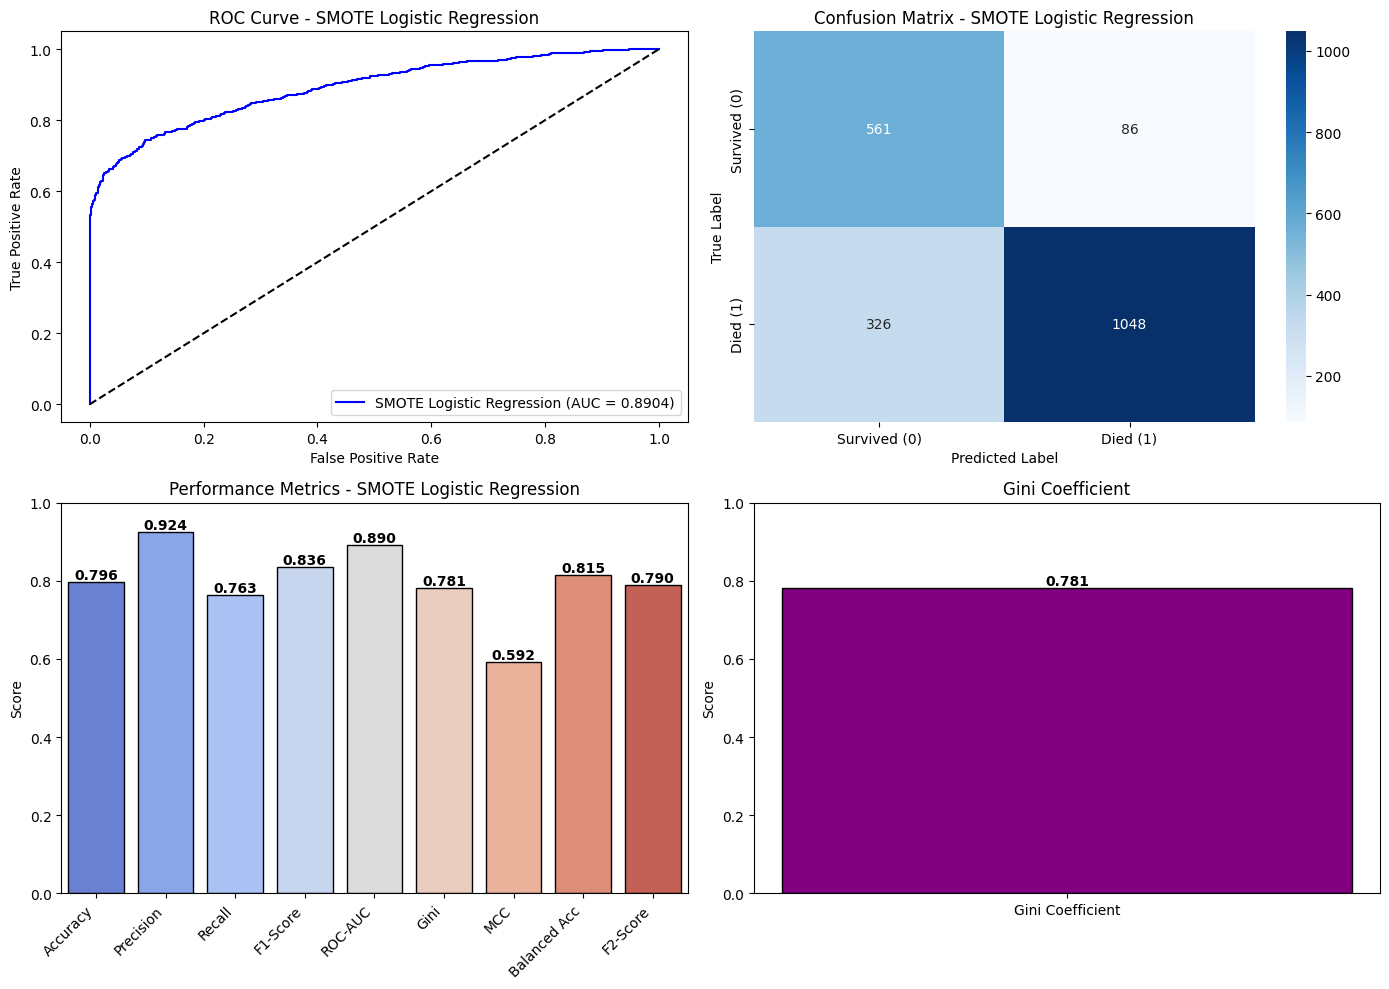

Evaluation plot saved to: ../visualizations\logit_smote_logistic_regression_evaluation.png


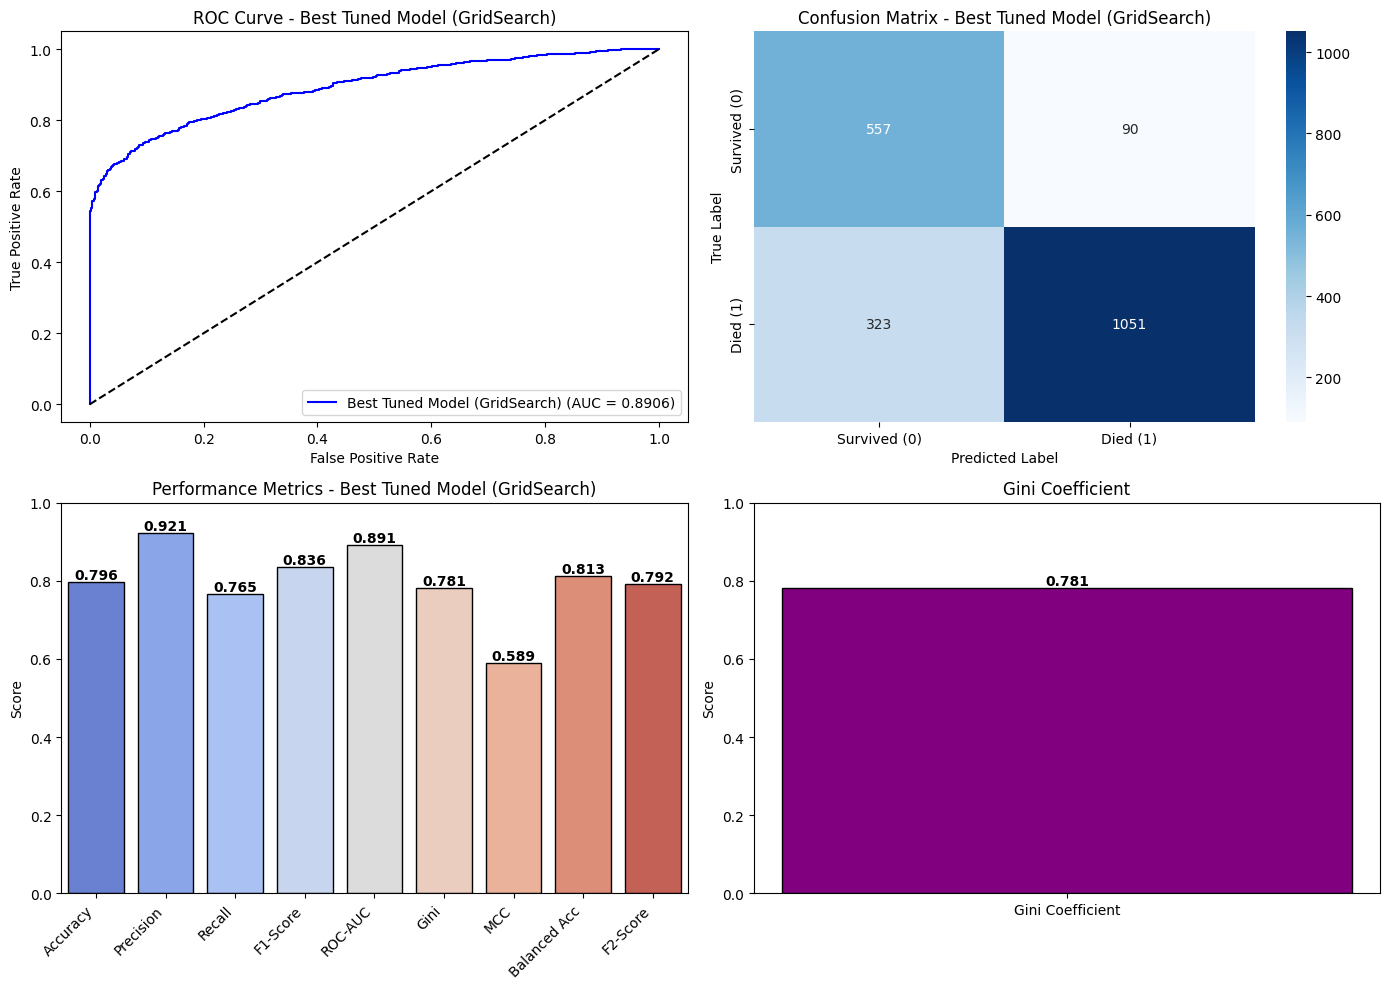

Evaluation plot saved to: ../visualizations\logit_best_tuned_model_(gridsearch)_evaluation.png


In [181]:
#evaluate_and_plot_model(results_logit, output_dir="../visualizations", prefix="logit") # old one
evaluate_and_plot_model_extended(results_logit, y_test_clean, output_dir="../visualizations", prefix="logit")

In [182]:
# Define the correct column names
performance_summary = pd.DataFrame.from_dict(results_logit, orient="index", 
    columns=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini", "MCC", "Balanced Accuracy", "F2-Score", "Confusion Matrix", "Predicted Probabilities"]
)

# Drop unnecessary columns for readability
performance_summary = performance_summary.drop(columns=["Confusion Matrix", "Predicted Probabilities"], errors="ignore")

# Sort models by ROC-AUC (best performing at the top)
performance_summary = performance_summary.sort_values(by="ROC-AUC", ascending=False)

from prettytable import PrettyTable

# Define the performance summary table
table = PrettyTable()
table.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini", "MCC", "Balanced Acc", "F2-Score"]

# Sort models by ROC-AUC (best performing at the top)
sorted_results = sorted(results_logit.items(), key=lambda x: x[1][4], reverse=True)

# Populate the table with model results
for model_name, values in sorted_results:
    table.add_row([model_name] + list(values[:9]))  # Exclude confusion matrix & predicted probabilities

# Print the formatted performance summary
print("\n=== Logistic Regression Model Performance Summary ===")
print(table)



=== Logistic Regression Model Performance Summary ===
+-------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|             Model             |      Accuracy      |     Precision      |       Recall       |      F1-Score      |      ROC-AUC       |        Gini        |        MCC         |    Balanced Acc    |      F2-Score      |
+-------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    Base Logistic Regression   | 0.8045522018802573 | 0.8519051042415529 | 0.8624454148471615 | 0.8571428571428571 | 0.8939546310482374 | 0.7879092620964747 | 0.547964903892575  | 0.7720264168517106 | 0.8603165384056919 |
|  Balanced Logistic Regression | 0.7926768926274121 

In [183]:
performance_summary_logit = performance_summary.copy()
performance_summary_logit

,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Gini,MCC,Balanced Accuracy,F2-Score
Base Logistic Regression,0.804552,0.851905,0.862445,0.857143,0.893955,0.787909,0.547965,0.772026,0.860317
Balanced Logistic Regression,0.792677,0.933697,0.748180,0.830707,0.893948,0.787896,0.595213,0.817676,0.779142
Best Tuned Model (GridSearch),0.795646,0.921122,0.764920,0.835785,0.890584,0.781169,0.588855,0.812908,0.791773
SMOTE Logistic Regression,0.796141,0.924162,0.762737,0.835726,0.890408,0.780816,0.592094,0.814908,0.790347


In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def extract_and_plot_coefficients(pipeline, pipeline_name, top_n=10):
    """
    Extracts coefficients from the logistic regression step of a pipeline,
    attempts to retrieve feature names, and plots the top positive/negative coefficients.

    Args:
        pipeline: A scikit-learn Pipeline (preprocessor + LogisticRegression).
        pipeline_name (str): A name to identify the pipeline (e.g. "Base Logistic Regression").
        top_n (int): Number of top positive and negative coefficients to plot.
    """

    # 1. Access the LogisticRegression step
    #    - If you named it "logreg", do pipeline["logreg"]
    #    - If you just appended it, do pipeline[-1]
    logreg_step = pipeline[-1]  # or pipeline["logreg"] if you used a step name
    if not hasattr(logreg_step, "coef_"):
        print(f"[{pipeline_name}] is not a LogisticRegression model, skipping.")
        return

    coefs = logreg_step.coef_.ravel()   # shape (1, n_features) → (n_features,)
    intercept = logreg_step.intercept_  # shape (1,) typically

    # 2. Attempt to retrieve feature names from the preprocessor
    #    The preprocessor is presumably pipeline[0] if your pipeline is (preprocessor, logistic).
    preprocessor_step = pipeline[0]
    try:
        # This works if your sklearn version + pipeline can handle .get_feature_names_out()
        feature_names = preprocessor_step.get_feature_names_out()
        # If you have a TargetEncoder, it might break or skip those columns
    except:
        # If we fail, either because of TargetEncoder or older sklearn,
        # you might have to use a manual name list or else fallback:
        feature_names = [f"Feature_{i}" for i in range(len(coefs))]
        print(f"[{pipeline_name}] Could not automatically retrieve feature names. Using generic Feature_i names.")

    # 3. Create a DataFrame for the coefficients
    coef_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coefs
    })

    # 4. Compute absolute value for sorting
    coef_df["AbsCoef"] = coef_df["Coefficient"].abs()
    coef_df.sort_values(by="AbsCoef", ascending=False, inplace=True)

    # 5. Print out the top 10 (or all) if you want
    print(f"\n=== Coefficients for {pipeline_name} ===")
    print(coef_df.head(2 * top_n))  # show top positives & negatives

    # 6. Plot the top positive & negative
    top_pos = coef_df.nlargest(top_n, "Coefficient")
    top_neg = coef_df.nsmallest(top_n, "Coefficient")
    plot_df = pd.concat([top_neg, top_pos]).sort_values("Coefficient")

    # Plot
    plt.figure(figsize=(15, 10))
    colors = ["red" if val < 0 else "blue" for val in plot_df["Coefficient"]]
    plt.barh(plot_df["Feature"], plot_df["Coefficient"], color=colors)
    plt.axvline(0, color="black", linestyle="--")
    plt.xlabel("Coefficient Value")
    plt.title(f"Top +/- {top_n} Coefficients: {pipeline_name}")
    plt.tight_layout()
    plt.show()



=== Coefficients for Base Logistic Regression ===
                                              Feature  Coefficient   AbsCoef
56      onehot_cat__sfdm2_imputed_no(M2 and SIP pres)    -3.684332  3.684332
53                  onehot_cat__sfdm2_imputed_SIP>=30    -3.235517  3.235517
54                  onehot_cat__sfdm2_imputed_Unknown    -3.217415  3.217415
97                                target_cat__dzgroup     3.204560  3.204560
55      onehot_cat__sfdm2_imputed_adl>=4 (>=5 if sur)    -2.839169  2.839169
19                                scale_num__hospdead     2.219362  2.219362
99                          target_cat__crea_category     1.438119  1.438119
81  onehot_cat__glucose_category_Extreme Hyperglyc...    -1.303987  1.303987
52            onehot_cat__sfdm2_imputed_Coma or Intub    -0.981208  0.981208
98                              target_cat__age_group     0.945218  0.945218
63                            onehot_cat__dnr_missing    -0.916684  0.916684
68                       

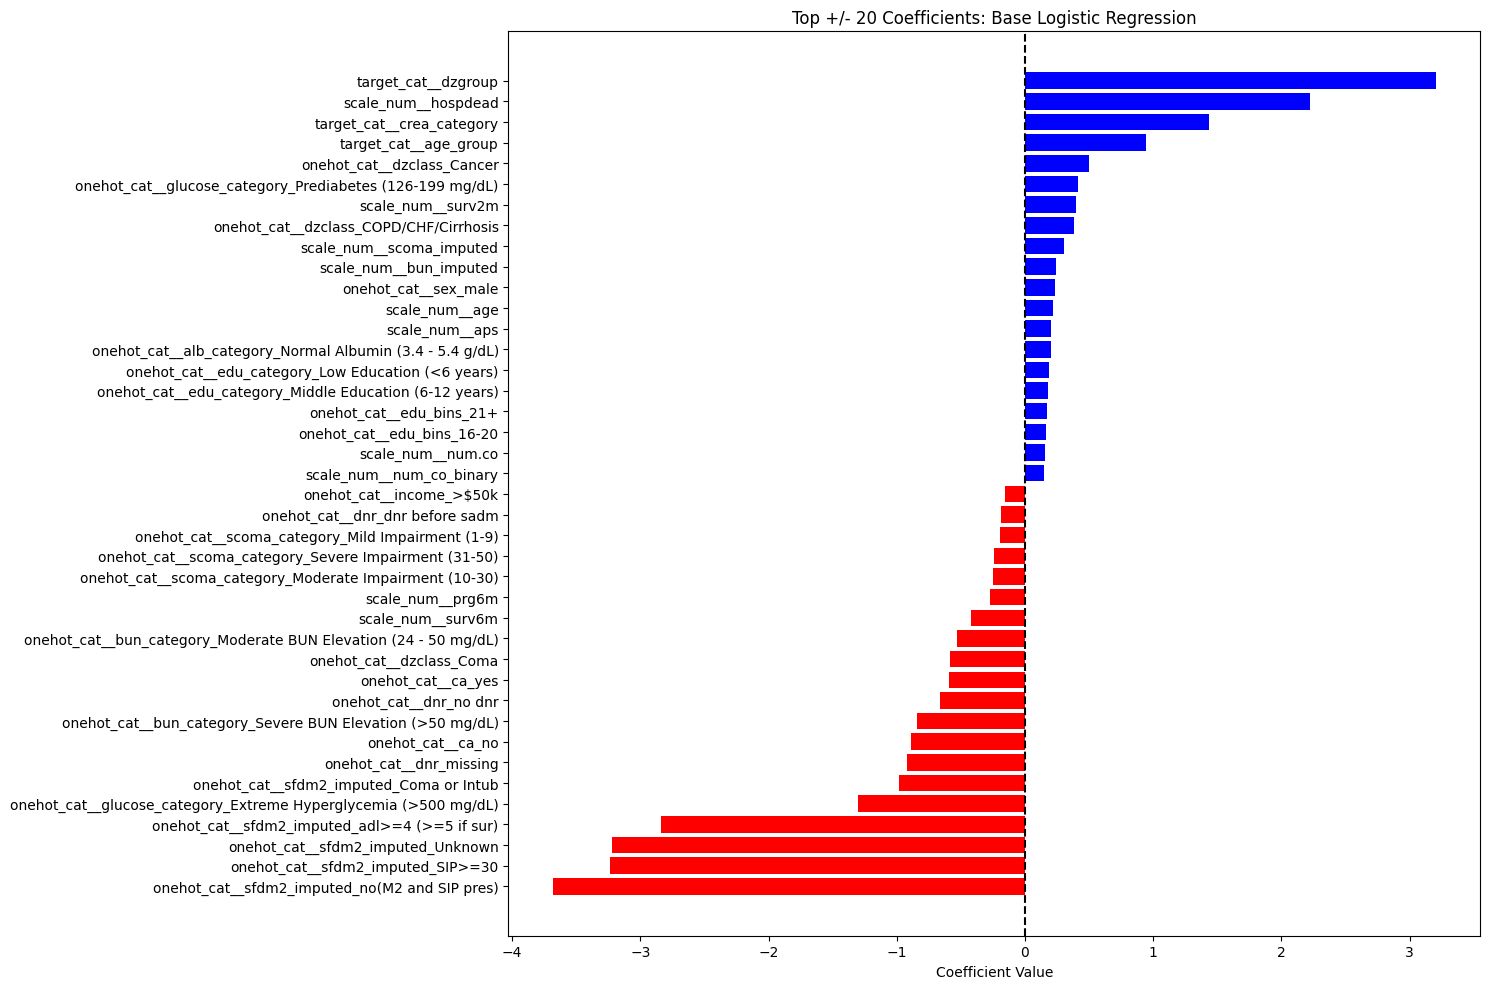


=== Coefficients for Balanced Logistic Regression ===
                                              Feature  Coefficient   AbsCoef
56      onehot_cat__sfdm2_imputed_no(M2 and SIP pres)    -4.032498  4.032498
54                  onehot_cat__sfdm2_imputed_Unknown    -3.557569  3.557569
53                  onehot_cat__sfdm2_imputed_SIP>=30    -3.548880  3.548880
55      onehot_cat__sfdm2_imputed_adl>=4 (>=5 if sur)    -3.185268  3.185268
97                                target_cat__dzgroup     3.020037  3.020037
19                                scale_num__hospdead     2.292556  2.292556
99                          target_cat__crea_category     1.444545  1.444545
81  onehot_cat__glucose_category_Extreme Hyperglyc...    -1.323697  1.323697
52            onehot_cat__sfdm2_imputed_Coma or Intub    -1.221469  1.221469
63                            onehot_cat__dnr_missing    -1.118633  1.118633
68                                  onehot_cat__ca_no    -0.891288  0.891288
98                   

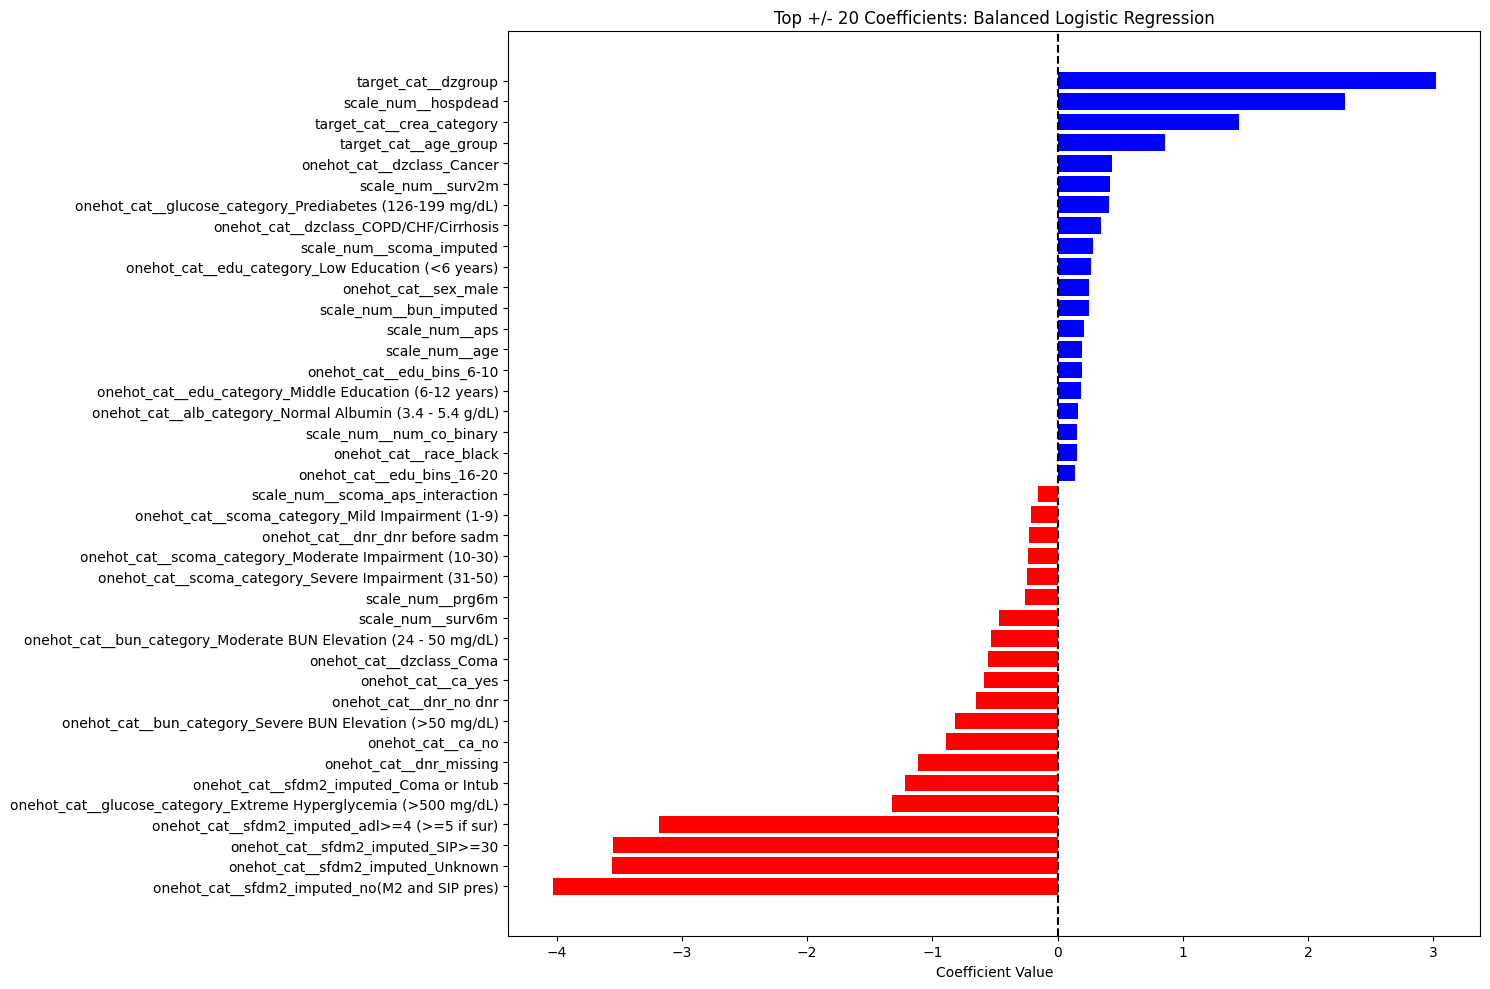


=== Coefficients for SMOTE Logistic Regression ===
                                              Feature  Coefficient   AbsCoef
56      onehot_cat__sfdm2_imputed_no(M2 and SIP pres)    -4.287501  4.287501
54                  onehot_cat__sfdm2_imputed_Unknown    -3.753958  3.753958
53                  onehot_cat__sfdm2_imputed_SIP>=30    -3.752400  3.752400
55      onehot_cat__sfdm2_imputed_adl>=4 (>=5 if sur)    -3.358181  3.358181
97                                target_cat__dzgroup     3.200224  3.200224
19                                scale_num__hospdead     2.329957  2.329957
99                          target_cat__crea_category     1.894060  1.894060
81  onehot_cat__glucose_category_Extreme Hyperglyc...    -1.699182  1.699182
63                            onehot_cat__dnr_missing    -1.379422  1.379422
52            onehot_cat__sfdm2_imputed_Coma or Intub    -1.194188  1.194188
80  onehot_cat__bun_category_Severe BUN Elevation ...    -0.929098  0.929098
68                      

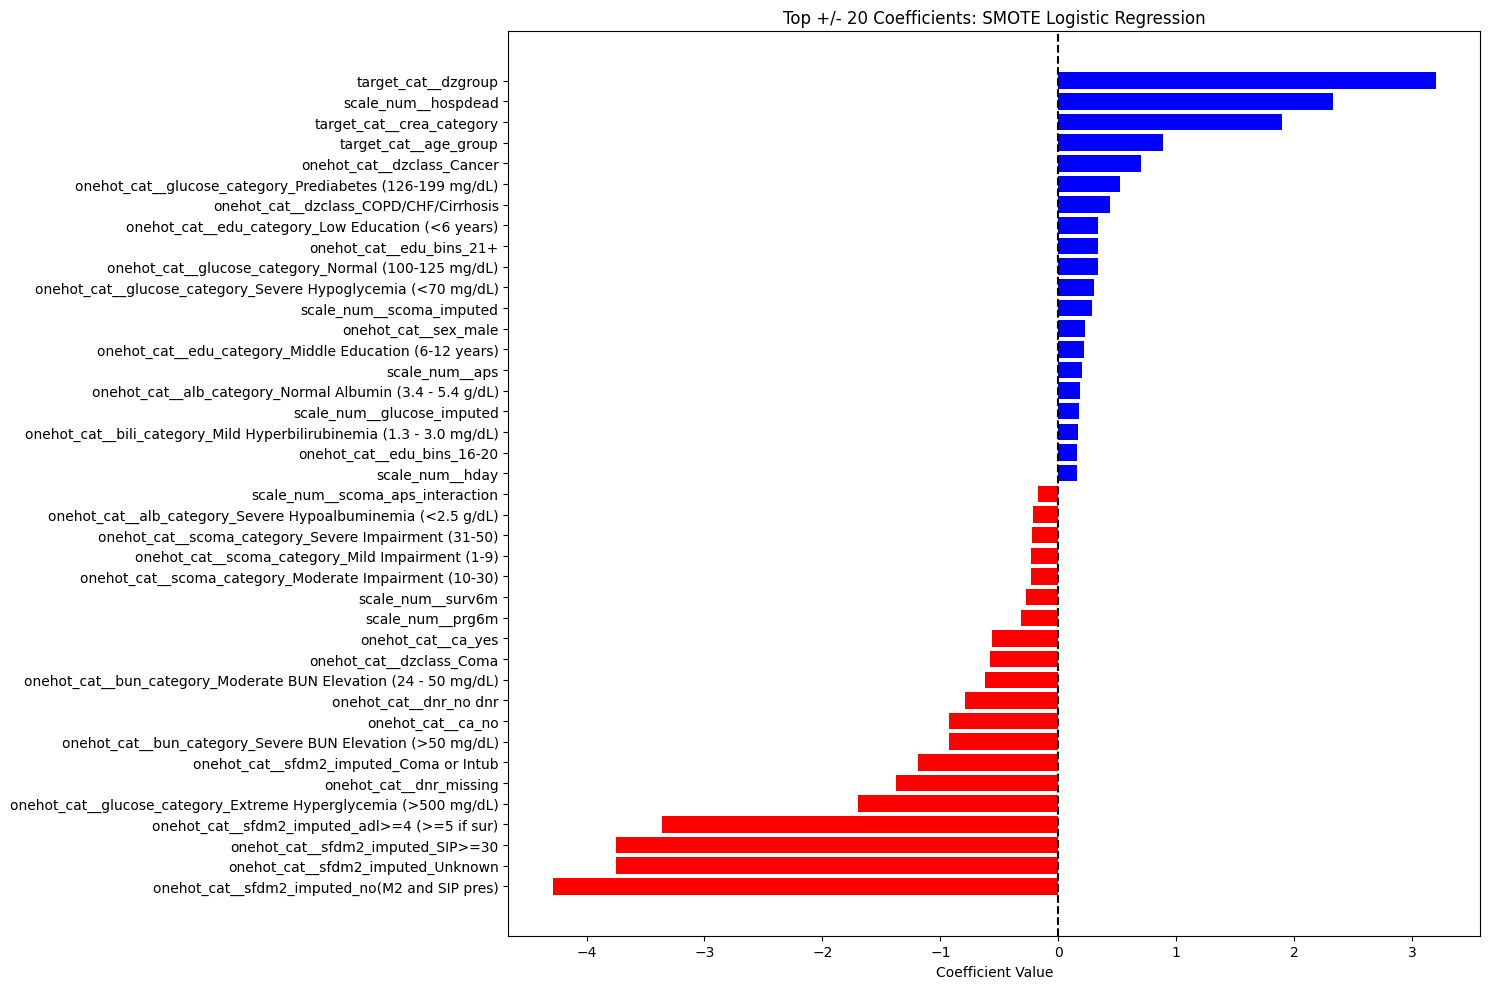


=== Coefficients for Best Tuned Model (GridSearch) ===
                                              Feature  Coefficient   AbsCoef
56      onehot_cat__sfdm2_imputed_no(M2 and SIP pres)    -5.598120  5.598120
99                          target_cat__crea_category     5.347207  5.347207
53                  onehot_cat__sfdm2_imputed_SIP>=30    -5.081607  5.081607
54                  onehot_cat__sfdm2_imputed_Unknown    -5.063623  5.063623
55      onehot_cat__sfdm2_imputed_adl>=4 (>=5 if sur)    -4.657363  4.657363
97                                target_cat__dzgroup     4.020843  4.020843
19                                scale_num__hospdead     2.816182  2.816182
52            onehot_cat__sfdm2_imputed_Coma or Intub    -2.546522  2.546522
81  onehot_cat__glucose_category_Extreme Hyperglyc...    -2.364735  2.364735
63                            onehot_cat__dnr_missing    -1.899320  1.899320
98                              target_cat__age_group     1.526769  1.526769
80  onehot_cat__bun_

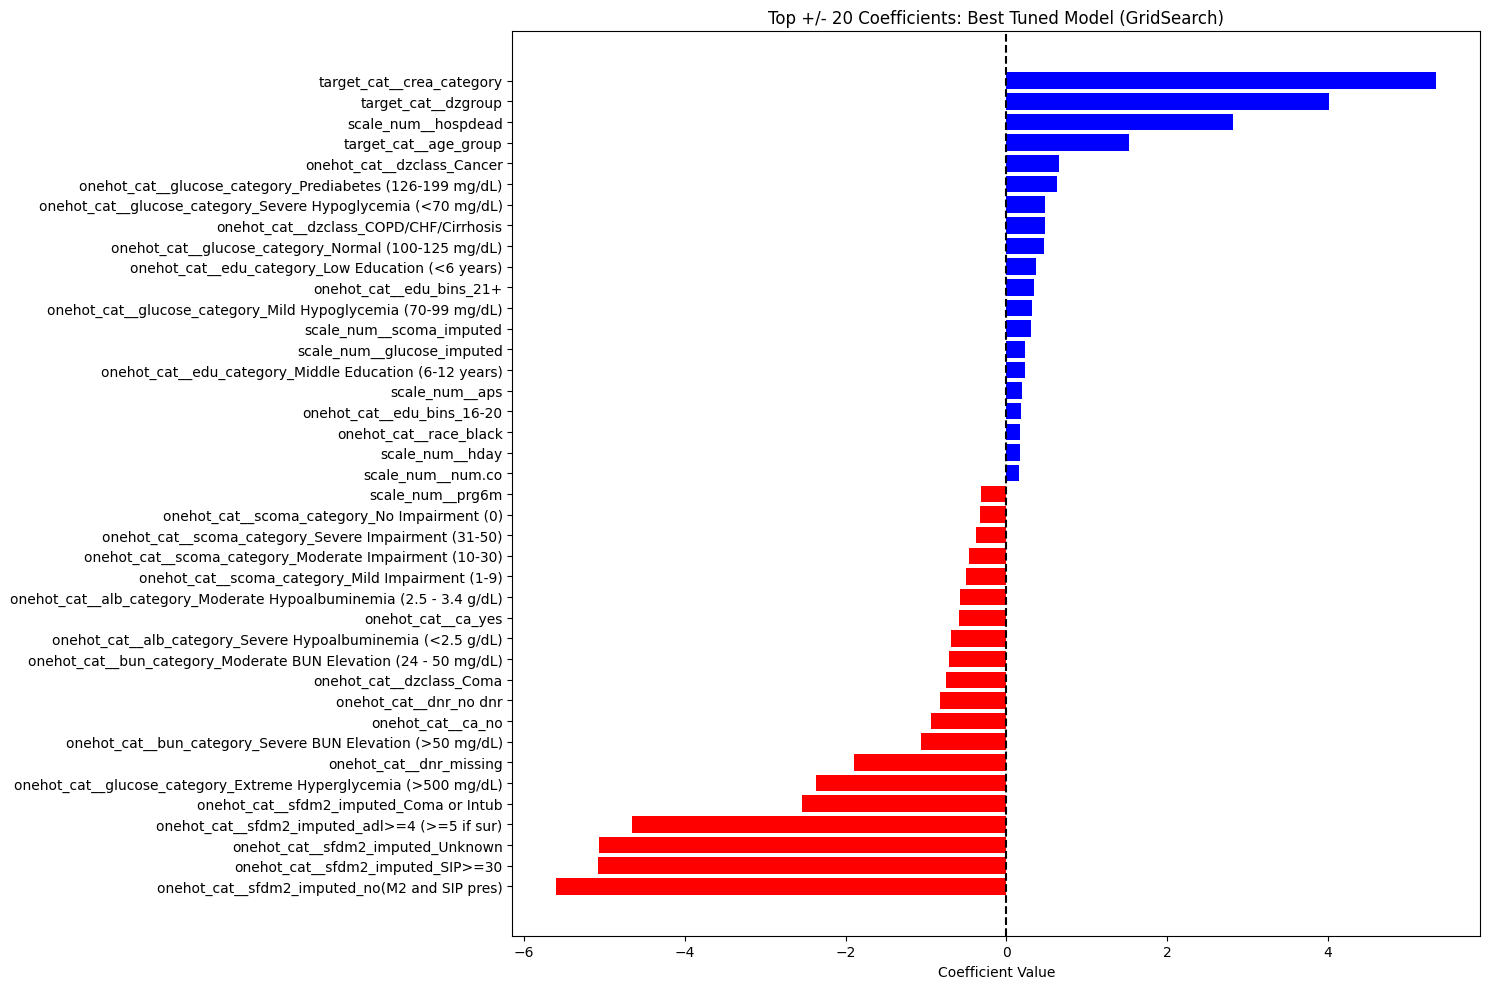

In [185]:
results_logit = {}
logit_models = {
    "Base Logistic Regression": logit_pipeline,
    "Balanced Logistic Regression": logit_pipeline_balanced,
    "SMOTE Logistic Regression": logit_pipeline_smote,
    "Best Tuned Model (GridSearch)": best_model
}

for name, model in logit_models.items():
    # Do your predictions & metrics
    y_pred = model.predict(X_test_clean)
    y_pred_prob = model.predict_proba(X_test_clean)[:, 1]

    accuracy = accuracy_score(y_test_clean, y_pred)
    precision = precision_score(y_test_clean, y_pred)
    recall = recall_score(y_test_clean, y_pred)
    f1 = f1_score(y_test_clean, y_pred)
    roc_auc = roc_auc_score(y_test_clean, y_pred_prob)
    cm = confusion_matrix(y_test_clean, y_pred)

    # Extra Metrics
    gini = 2 * roc_auc - 1
    mcc = matthews_corrcoef(y_test_clean, y_pred)
    balanced_acc = balanced_accuracy_score(y_test_clean, y_pred)
    f2 = fbeta_score(y_test_clean, y_pred, beta=2)

    results_logit[name] = (
        accuracy, precision, recall, f1, roc_auc, gini, mcc, balanced_acc, f2, cm, y_pred_prob
    )

    # *** Now extract & plot coefficients ***
    extract_and_plot_coefficients(
        pipeline=model, 
        pipeline_name=name, 
        top_n=20
    )


Logistic regression is a widely used statistical method for binary classification problems. In this case, it serves as a baseline model for predicting patient mortality (`death`). The model estimates the probability that an instance belongs to a particular class (e.g., `survival` vs. `death`) using a logistic `(sigmoid)` function.

When it comes to model performance: 

- If recall is the priority: Base Logistic Regression has the highest recall (0.8624), meaning it captures more true positives.

- If precision is the priority: Balanced Logistic Regression has the highest precision (0.9337), meaning fewer false positives.

- `If balanced accuracy is the priority: Balanced Logistic Regression leads (0.8177), indicating a well-balanced model.` 

- If overall discrimination (ROC-AUC) is key: Base Logistic Regression has the highest ROC-AUC (0.8939).

- If F2-Score (recall-weighted) is important: Base Logistic Regression performs best (0.8603).

I would say balanced dataset in this case is most important beacause of least false positive, which in medical (if we can name it that way) data is very important
But on the other hand these are some baseline models that i could have done a little bit differently

## 2. RANDOM FOREST

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn / XGBoost imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)
import xgboost as xgb

In [187]:
# Dictionary to store Random Forest results
results_rf = {}

# 1. Baseline Random Forest (Clean, label-encoded)
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    random_state=420
)

# Fit on the label-encoded clean data
rf_baseline.fit(X_train_clean_tree, y_train_clean)

# Evaluate with your 'evaluate_model_extended' function
# (It returns: accuracy, precision, recall, f1, f2, roc_auc, gini, mcc, balanced_acc, y_pred_prob)
rf_baseline_eval = evaluate_model_extended(
    rf_baseline, 
    X_test_clean_tree, 
    y_test_clean, 
    model_name="Baseline Random Forest"
)

# The function does not return the confusion matrix, so let's add it ourselves:
y_pred_prob_baseline = rf_baseline_eval[-1]  # last element is y_pred_prob
y_pred_baseline = (y_pred_prob_baseline >= 0.5).astype(int)
cm_baseline = confusion_matrix(y_test_clean, y_pred_baseline)

# Reorder to match the format in logistic regression:
# (Accuracy, Precision, Recall, F1, ROC-AUC, Gini, MCC, Balanced Acc, F2, cm, y_pred_prob)
# Currently we have: (acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob)
acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob = rf_baseline_eval

results_rf["Baseline Random Forest"] = (
    acc,          # Accuracy
    prec,         # Precision
    rec,          # Recall
    f1,           # F1
    roc_auc,      # ROC-AUC
    gini,         # Gini
    mcc,          # MCC
    bal_acc,      # Balanced Acc
    f2,           # F2
    cm_baseline,  # Confusion Matrix
    y_prob        # Predicted Probabilities
)


=== Baseline Random Forest Performance ===
Accuracy:         0.917
Precision:        0.941
Recall:           0.936
F1-Score:         0.939
F2-Score:         0.937
ROC-AUC:          0.9749
Gini Coefficient: 0.9498
MCC:              0.8097
Balanced Accuracy: 0.9062


In [188]:
# time to hypertune my model
from sklearn.model_selection import GridSearchCV

# Parameter Grid for RandomForest
rf_param_grid = {
    "n_estimators": [100, 200, 300, 400, 500, 550], #50, 
    "max_depth": [None, 5, 10, 20, 25, 30],
    "class_weight": [None, "balanced"]
}

rf_gridsearch = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring="roc_auc",        # choose your metric
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit on the label-encoded clean training set
rf_gridsearch.fit(X_train_clean_tree, y_train_clean)

# Get the best RF model
best_rf = rf_gridsearch.best_estimator_
print("\n=== Best Hyperparameters for RandomForest ===")
print(rf_gridsearch.best_params_)

# Evaluate the tuned Random Forest
rf_tuned_eval = evaluate_model_extended(
    best_rf,
    X_test_clean_tree,
    y_test_clean,
    model_name="Tuned Random Forest"
)

# Add Confusion Matrix
y_pred_prob_tuned = rf_tuned_eval[-1]  # last item is y_pred_prob
y_pred_tuned = (y_pred_prob_tuned >= 0.5).astype(int)
cm_tuned = confusion_matrix(y_test_clean, y_pred_tuned)

# Reorder the tuple to match your logistic format
acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob = rf_tuned_eval

results_rf["Tuned Random Forest"] = (
    acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm_tuned, y_prob
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits

=== Best Hyperparameters for RandomForest ===
{'class_weight': None, 'max_depth': 20, 'n_estimators': 500}

=== Tuned Random Forest Performance ===
Accuracy:         0.916
Precision:        0.939
Recall:           0.937
F1-Score:         0.938
F2-Score:         0.938
ROC-AUC:          0.9763
Gini Coefficient: 0.9526
MCC:              0.8069
Balanced Accuracy: 0.9038


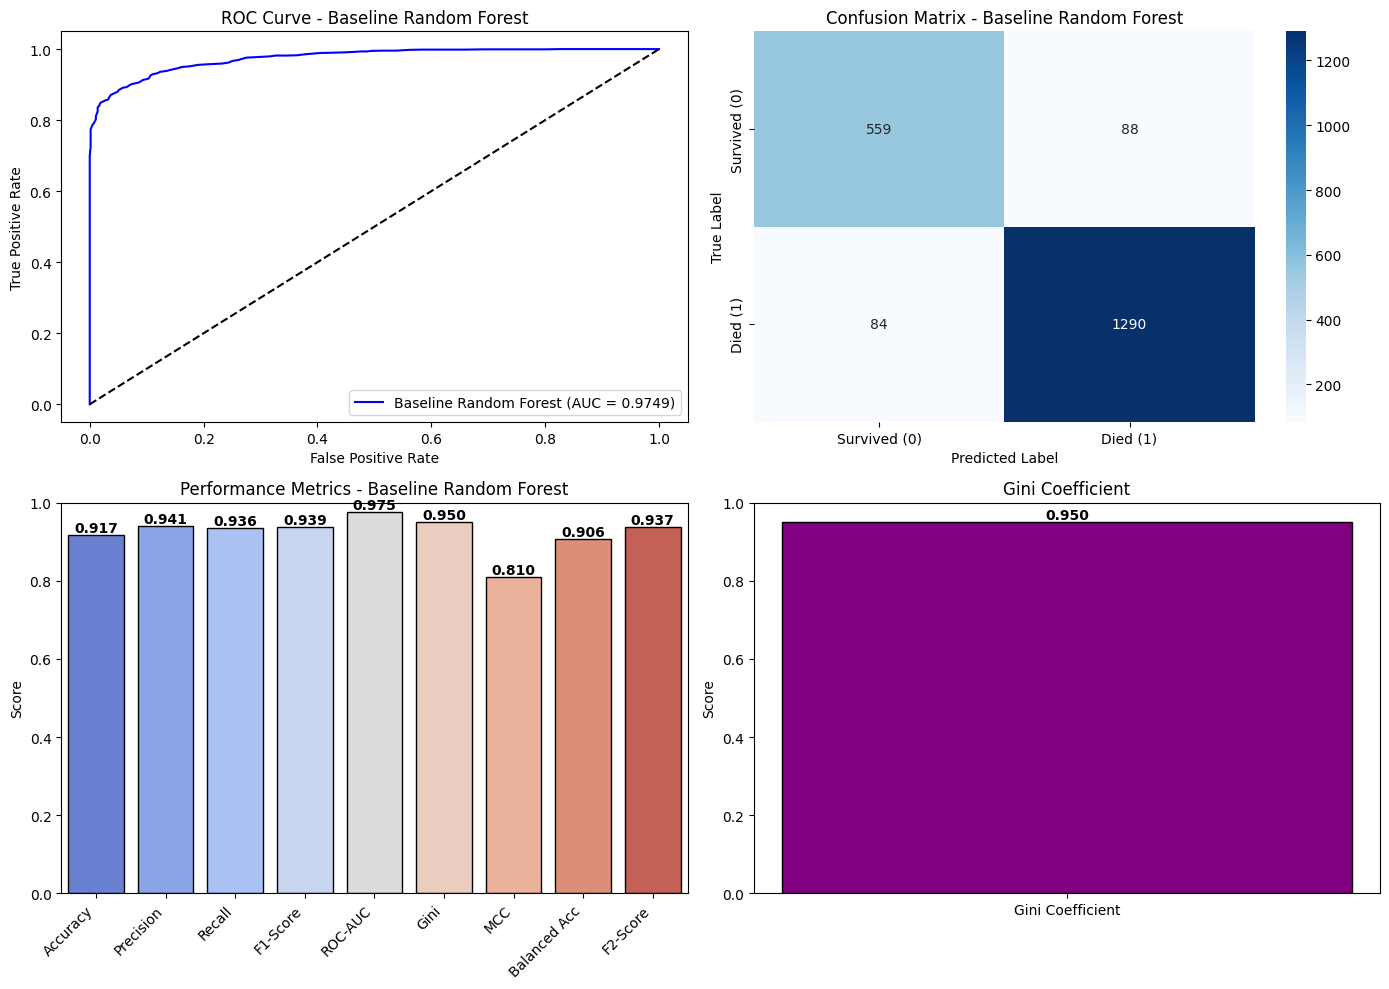

Evaluation plot saved to: ../visualizations\rf_baseline_random_forest_evaluation.png


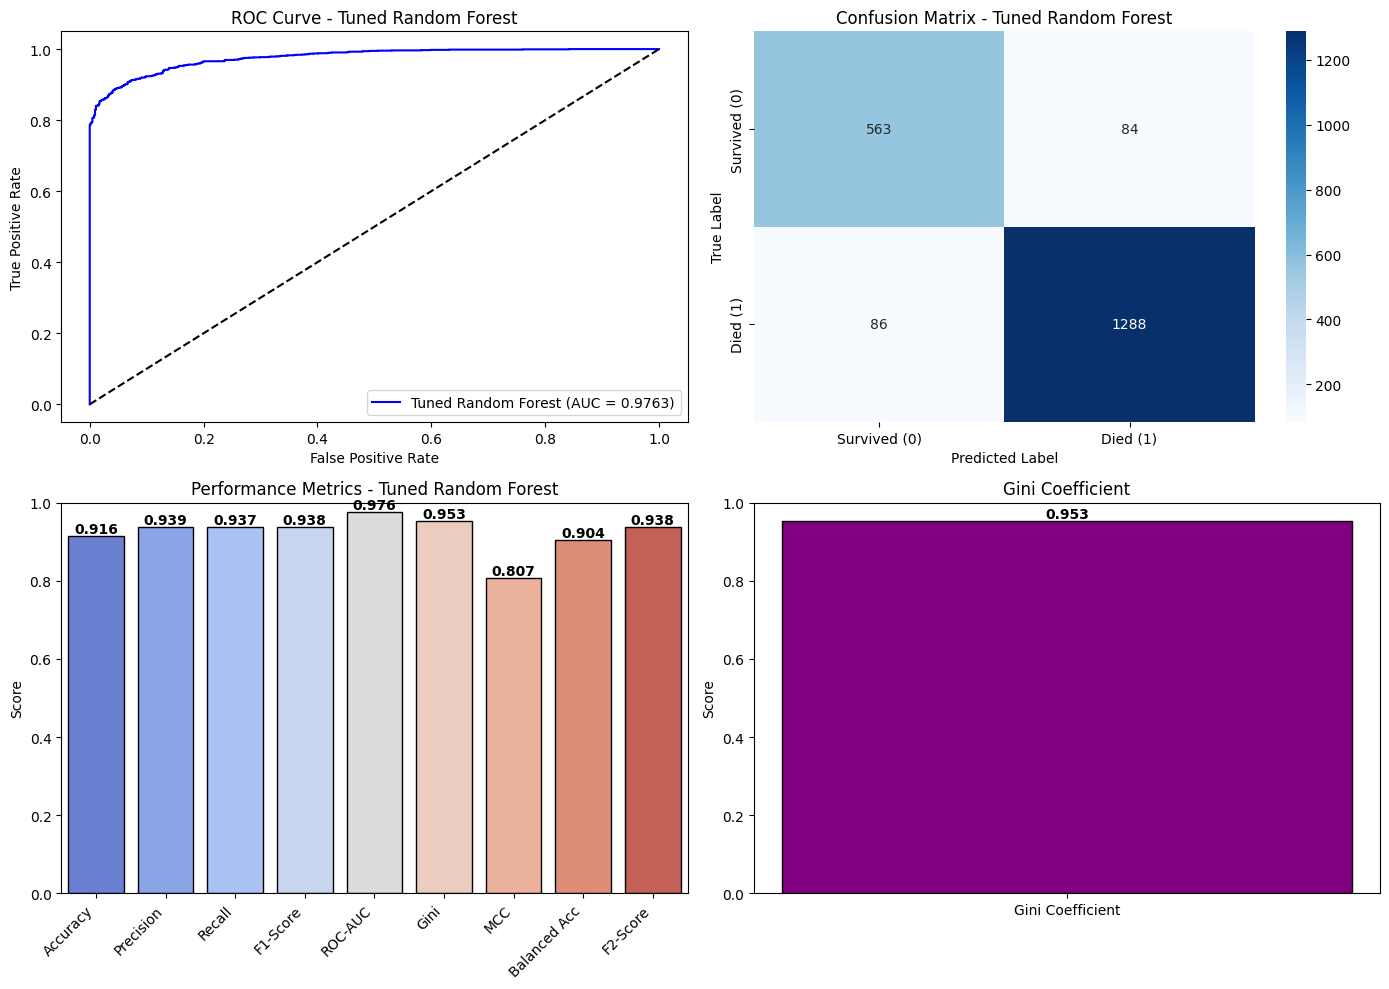

Evaluation plot saved to: ../visualizations\rf_tuned_random_forest_evaluation.png

=== Random Forest Model Performance Summary ===
                        Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
Tuned Random Forest     0.915883   0.938776  0.937409  0.938092  0.976314   
Baseline Random Forest  0.916873   0.941435  0.935953  0.938686  0.974898   

                            Gini       MCC  Balanced Accuracy  F2-Score  
Tuned Random Forest     0.952628  0.806921           0.903790  0.937682  
Baseline Random Forest  0.949796  0.809691           0.906153  0.937045  
+------------------------+----------+-----------+--------+----------+---------+--------+--------+--------------+----------+
|         Model          | Accuracy | Precision | Recall | F1-Score | ROC-AUC |  Gini  |  MCC   | Balanced Acc | F2-Score |
+------------------------+----------+-----------+--------+----------+---------+--------+--------+--------------+----------+
| Baseline Random Forest |  0.917   |   0.9

In [189]:
# Let's import any needed modules
from prettytable import PrettyTable
import os

# Evaluate & plot Random Forest models
evaluate_and_plot_model_extended(results_rf, y_test_clean, output_dir="../visualizations", prefix="rf")

# Build a performance summary DataFrame or table
rf_performance_summary = pd.DataFrame.from_dict(
    results_rf, 
    orient="index",
    columns=[
        "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini", 
        "MCC", "Balanced Accuracy", "F2-Score", "Confusion Matrix", "Predicted Probabilities"
    ]
)

# Drop unneeded columns for readability
rf_performance_summary.drop(["Confusion Matrix", "Predicted Probabilities"], axis=1, inplace=True)

# Sort by ROC-AUC descending
rf_performance_summary.sort_values(by="ROC-AUC", ascending=False, inplace=True)

print("\n=== Random Forest Model Performance Summary ===")
print(rf_performance_summary)

# Or use PrettyTable if you prefer
rf_table = PrettyTable()
rf_table.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini", "MCC", "Balanced Acc", "F2-Score"]

for model_name, vals in results_rf.items():
    # vals is (acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm, prob)
    rf_table.add_row([
        model_name, 
        round(vals[0], 3),  # Accuracy
        round(vals[1], 3),  # Precision
        round(vals[2], 3),  # Recall
        round(vals[3], 3),  # F1
        round(vals[4], 4),  # ROC-AUC
        round(vals[5], 4),  # Gini
        round(vals[6], 4),  # MCC
        round(vals[7], 4),  # Balanced Acc
        round(vals[8], 4)   # F2
    ])

print(rf_table)


In [190]:
results_rf

{'Baseline Random Forest': (0.9168728352300841,
  0.9414348462664714,
  0.9359534206695779,
  0.9386861313868613,
  0.9748981414613185,
  0.949796282922637,
  0.8096905487792906,
  0.9061529081709558,
  0.9370445934129992,
  array([[ 559,   88],
         [  84, 1290]], dtype=int64),
  array([1.  , 0.98, 1.  , ..., 0.94, 0.9 , 0.46])),
 'Tuned Random Forest': (0.9158832261256804,
  0.9387755102040817,
  0.9374090247452693,
  0.9380917698470502,
  0.9763138120403428,
  0.9526276240806857,
  0.8069212291734893,
  0.9037895201006099,
  0.9376820034944671,
  array([[ 563,   84],
         [  86, 1288]], dtype=int64),
  array([0.994     , 0.982     , 0.996     , ..., 0.982     , 0.932     ,
         0.40921374]))}

In [191]:
results_logit

{'Base Logistic Regression': (0.8045522018802573,
  0.8519051042415529,
  0.8624454148471615,
  0.8571428571428571,
  0.8939546310482374,
  0.7879092620964747,
  0.547964903892575,
  0.7720264168517106,
  0.8603165384056919,
  array([[ 441,  206],
         [ 189, 1185]], dtype=int64),
  array([0.99999221, 0.99810397, 0.999935  , ..., 0.99686959, 0.98944681,
         0.47800694])),
 'Balanced Logistic Regression': (0.7926768926274121,
  0.9336966394187103,
  0.7481804949053857,
  0.8307070707070707,
  0.893947881724857,
  0.7878957634497139,
  0.5952129521858387,
  0.8176760279781952,
  0.7791420342579961,
  array([[ 574,   73],
         [ 346, 1028]], dtype=int64),
  array([0.99998977, 0.99778067, 0.99992386, ..., 0.99526109, 0.98471433,
         0.28832476])),
 'SMOTE Logistic Regression': (0.7961405244928254,
  0.9241622574955908,
  0.7627365356622998,
  0.835725677830941,
  0.8904078616118734,
  0.7808157232237467,
  0.5920936701729846,
  0.8149076805050294,
  0.7903469079939668,
  

In [192]:
# Merge your logistic dict with the RF dict
results_all = {}
results_all.update(results_logit) # results_logit = 
results_all.update(results_rf)

# Evaluate & plot everything:
#evaluate_and_plot_model_extended(results_all, y_test_clean, output_dir="../visualizations", prefix="all_models")

# Build a combined summary
performance_summary_all = pd.DataFrame.from_dict(results_all, orient="index",
    columns=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini", "MCC", "Balanced Accuracy", "F2-Score", "Confusion Matrix", "Predicted Probabilities"]
)
performance_summary_all.drop(["Confusion Matrix", "Predicted Probabilities"], axis=1, inplace=True)
performance_summary_all.sort_values(by="ROC-AUC", ascending=False, inplace=True)

print("\n=== Combined Model Performance Summary (Logit + RF) ===")
print(performance_summary_all)



=== Combined Model Performance Summary (Logit + RF) ===
                               Accuracy  Precision    Recall  F1-Score  \
Tuned Random Forest            0.915883   0.938776  0.937409  0.938092   
Baseline Random Forest         0.916873   0.941435  0.935953  0.938686   
Base Logistic Regression       0.804552   0.851905  0.862445  0.857143   
Balanced Logistic Regression   0.792677   0.933697  0.748180  0.830707   
Best Tuned Model (GridSearch)  0.795646   0.921122  0.764920  0.835785   
SMOTE Logistic Regression      0.796141   0.924162  0.762737  0.835726   

                                ROC-AUC      Gini       MCC  \
Tuned Random Forest            0.976314  0.952628  0.806921   
Baseline Random Forest         0.974898  0.949796  0.809691   
Base Logistic Regression       0.893955  0.787909  0.547965   
Balanced Logistic Regression   0.893948  0.787896  0.595213   
Best Tuned Model (GridSearch)  0.890584  0.781169  0.588855   
SMOTE Logistic Regression      0.890408  0.780

In [193]:
print(type(X_train_clean_tree))


<class 'pandas.core.frame.DataFrame'>



=== Baseline RandomForest Feature Importances (Top 35) ===
                Feature  Importance
65      glucose_imputed    0.192178
64        sfdm2_imputed    0.101191
23             hospdead    0.050340
38               surv6m    0.032315
51          bun_imputed    0.031546
8                   dnr    0.030988
37               surv2m    0.026580
11              dzgroup    0.023992
53  bun_age_interaction    0.019803
31                prg6m    0.019367
9                dnrday    0.017384
1                   age    0.016866
66     glucose_category    0.015478
4                    ca    0.014654
10              dzclass    0.014196
3               avtisst    0.014002
5               charges    0.012809
2                   aps    0.012124
36                  sps    0.012120
30                prg2m    0.011935
24                  hrt    0.011717
41              totmcst    0.011159
40               totcst    0.011136
28                 pafi    0.011016
27               num.co    0.010978
43  

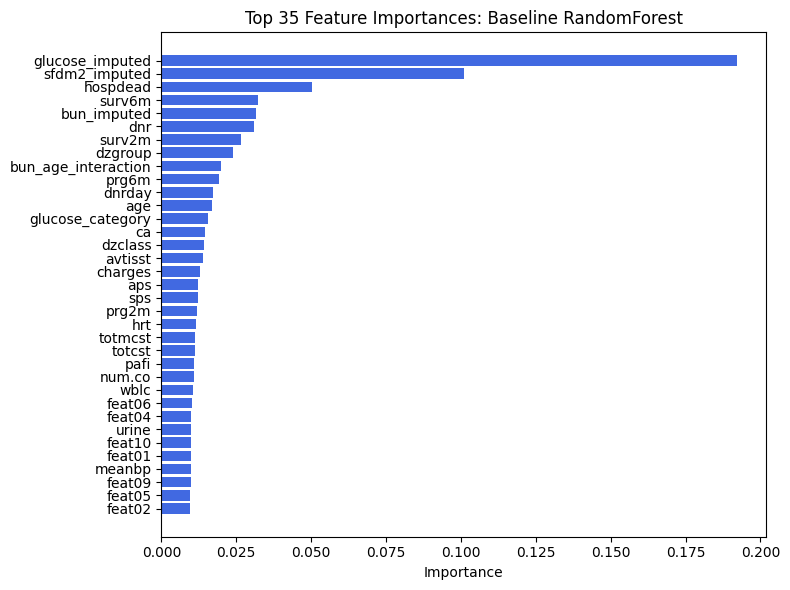


=== Tuned RandomForest Feature Importances (Top 35) ===
                Feature  Importance
65      glucose_imputed    0.191053
64        sfdm2_imputed    0.097761
23             hospdead    0.050199
8                   dnr    0.035929
38               surv6m    0.032703
51          bun_imputed    0.028415
37               surv2m    0.023931
11              dzgroup    0.023656
31                prg6m    0.022673
53  bun_age_interaction    0.020665
66     glucose_category    0.020279
4                    ca    0.017046
1                   age    0.016503
9                dnrday    0.015667
3               avtisst    0.014105
5               charges    0.013611
10              dzclass    0.012414
36                  sps    0.012281
40               totcst    0.012079
2                   aps    0.011872
41              totmcst    0.011288
24                  hrt    0.011187
28                 pafi    0.011083
43                 wblc    0.010957
30                prg2m    0.010795
27     

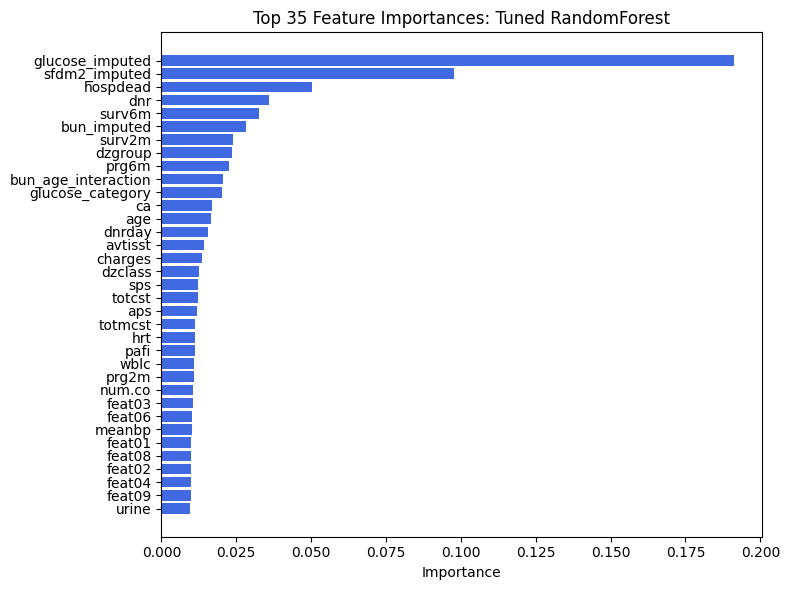

In [194]:
import matplotlib.pyplot as plt
import numpy as np

def show_rf_importances(rf_model, X_train_tree, model_name="RandomForest", top_n=15):
    """
    Prints and plots the top feature importances from a fitted RandomForest model.
    
    Args:
        rf_model: Fitted RandomForestClassifier.
        X_train_tree: The label-encoded DataFrame used to train the model 
                      (with .columns for each feature).
        model_name (str): A name/label for the model (used in printing & plots).
        top_n (int): How many top features to show in the bar chart.
    """

    # 1) Grab the feature_importances_
    importances = rf_model.feature_importances_
    
    if hasattr(X_train_tree, "columns"):
        feature_names = X_train_tree.columns
    else:
        # fallback if it's an array
        feature_names = [f"Feature_{i}" for i in range(len(importances))]

    # 2) Build a table of feature names + importances
    imp_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    })

    # 3) Sort by importance descending
    imp_df.sort_values(by="Importance", ascending=False, inplace=True)

    print(f"\n=== {model_name} Feature Importances (Top {top_n}) ===")
    print(imp_df.head(top_n))

    # 4) Plot top_n as a bar chart
    top_n_df = imp_df.head(top_n).iloc[::-1]  # reverse for a top-down barh
    plt.figure(figsize=(8, 6))
    plt.barh(top_n_df["Feature"], top_n_df["Importance"], color="royalblue")
    plt.title(f"Top {top_n} Feature Importances: {model_name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# Example usage with your baseline & tuned RF:
show_rf_importances(rf_baseline, X_train_clean_tree, model_name="Baseline RandomForest", top_n=35)
show_rf_importances(best_rf, X_train_clean_tree, model_name="Tuned RandomForest", top_n=35)


In [195]:
import shap
import numpy as np
import matplotlib.pyplot as plt

def explain_rf_with_shap(rf_model, X_test_tree, model_name="RandomForest"):
    """
    Uses SHAP to produce local/global explanations of a RandomForest model.
    """
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test_tree)
    
    print(f"\n=== SHAP Explanation for {model_name} ===")

    # Check if we got a 3D array shape: (n_samples, n_features, 2)
    # for a 2-class problem
    if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        # e.g. shape = (n_samples, n_features, 2)
        print("Detected new SHAP format with shape:", shap_values.shape)
        # take shap_values for the 'positive' class (class index=1)
        shap_values_for_class1 = shap_values[:, :, 1]
    elif isinstance(shap_values, list) and len(shap_values) == 2:
        # older style: shap_values[1] is for class 1
        print("Detected older SHAP format returning list of arrays for each class.")
        shap_values_for_class1 = shap_values[1]
    else:
        # fallback: assume shap_values is already the one we need
        print(f"Detected shap_values with shape: {np.array(shap_values).shape}")
        shap_values_for_class1 = shap_values

    # Now shap_values_for_class1 should be (n_samples, n_features)
    print("Final shap_values shape for plotting:", shap_values_for_class1.shape)

    # Global importance (bar chart)
    shap.summary_plot(shap_values_for_class1, X_test_tree, plot_type="bar", show=False)
    plt.title(f"{model_name} - SHAP Feature Importance (Bar)")
    plt.show()

    # Detailed summary (beeswarm)
    shap.summary_plot(shap_values_for_class1, X_test_tree, show=False)
    plt.title(f"{model_name} - SHAP Feature Impact (Beeswarm)")
    plt.show()

    # Local explanation example (first sample) - requires Jupyter
    # shap.force_plot(
    #     explainer.expected_value[1],
    #     shap_values_for_class1[0,:],
    #     X_test_tree.iloc[0,:]
    # )



=== SHAP Explanation for Baseline RandomForest ===
Detected new SHAP format with shape: (2021, 68, 2)
Final shap_values shape for plotting: (2021, 68)


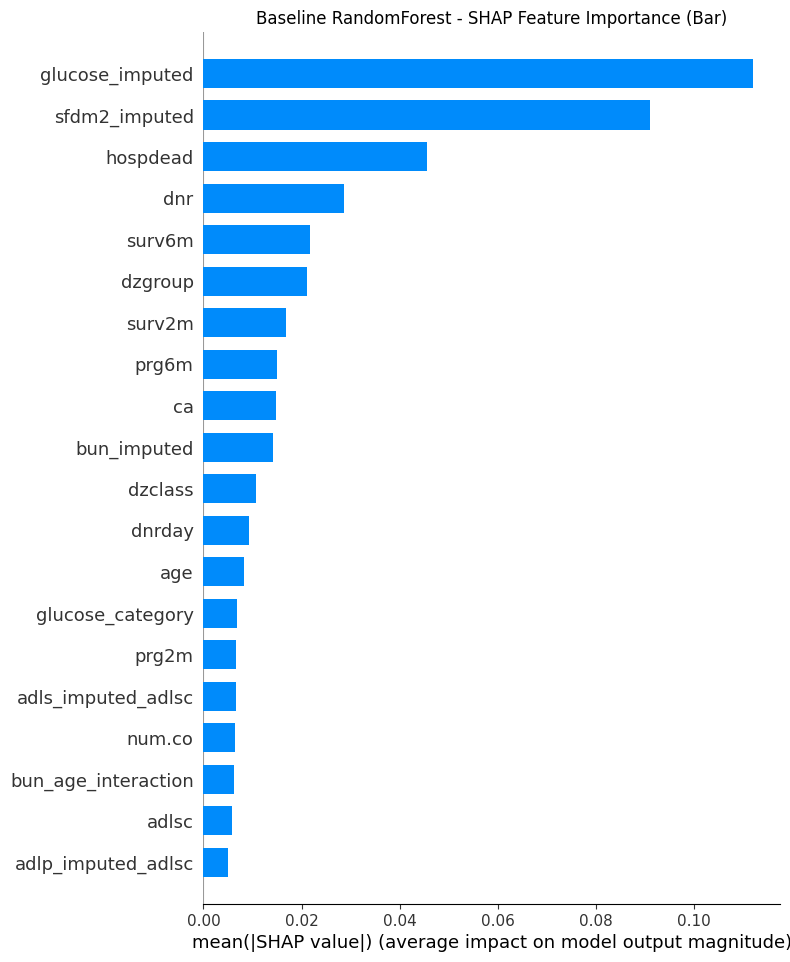

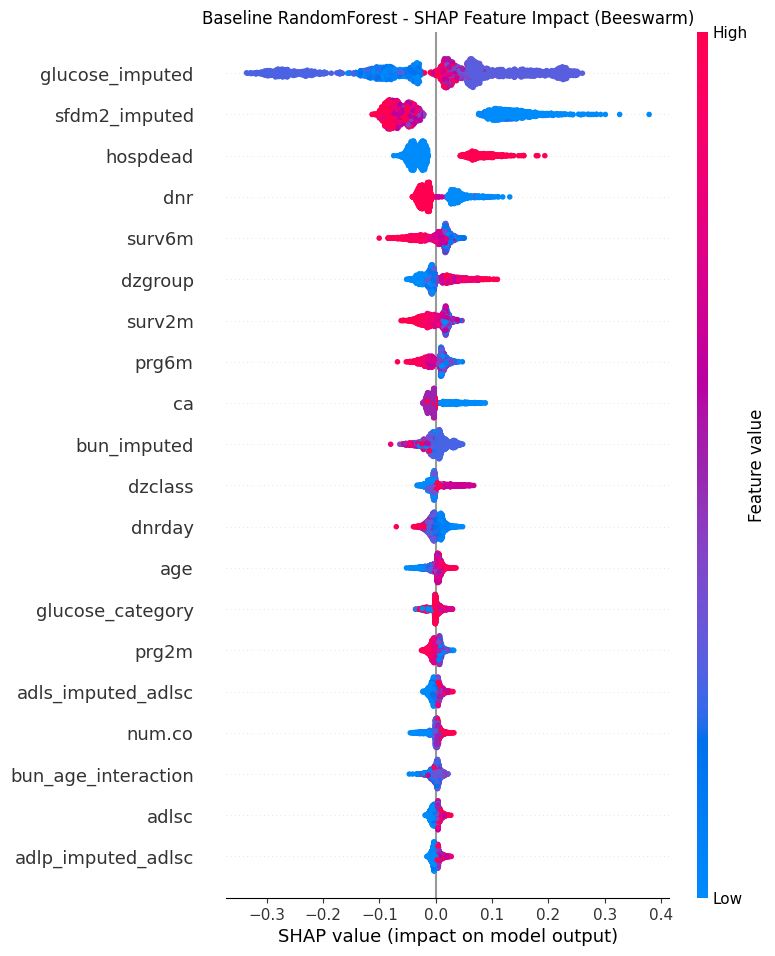

In [196]:
# For Baseline RandomForest
explain_rf_with_shap(
    rf_model=rf_baseline, 
    X_test_tree=X_test_clean_tree, 
    model_name="Baseline RandomForest"
)

In [ ]:
# For Tuned RandomForest
explain_rf_with_shap(
    rf_model=best_rf, 
    X_test_tree=X_test_clean_tree, 
    model_name="Tuned RandomForest"
)


In [157]:
results_all

{'Base Logistic Regression': (0.8045522018802573,
  0.8519051042415529,
  0.8624454148471615,
  0.8571428571428571,
  0.8939546310482374,
  0.7879092620964747,
  0.547964903892575,
  0.7720264168517106,
  0.8603165384056919,
  array([[ 441,  206],
         [ 189, 1185]], dtype=int64),
  array([0.99999221, 0.99810397, 0.999935  , ..., 0.99686959, 0.98944681,
         0.47800694])),
 'Balanced Logistic Regression': (0.7926768926274121,
  0.9336966394187103,
  0.7481804949053857,
  0.8307070707070707,
  0.893947881724857,
  0.7878957634497139,
  0.5952129521858387,
  0.8176760279781952,
  0.7791420342579961,
  array([[ 574,   73],
         [ 346, 1028]], dtype=int64),
  array([0.99998977, 0.99778067, 0.99992386, ..., 0.99526109, 0.98471433,
         0.28832476])),
 'SMOTE Logistic Regression': (0.7961405244928254,
  0.9241622574955908,
  0.7627365356622998,
  0.835725677830941,
  0.8904078616118734,
  0.7808157232237467,
  0.5920936701729846,
  0.8149076805050294,
  0.7903469079939668,
  

## XGBOOST - due to some bugs (bugs that i have shown during my presentation, and up until now they have not been resolved, this part of the code will be done in second ENV - used XGBOOST file located in notebook)

In [162]:
import numpy as np
import joblib
import os

# Save only the required train-test datasets for XGBoost
np.save("../XGBOOST/X_train_clean_mean.npy", X_train_clean_mean)
np.save("../XGBOOST/X_test_clean_mean.npy", X_test_clean_mean)
np.save("../XGBOOST/y_train_clean.npy", y_train_clean)
np.save("../XGBOOST/y_test_clean.npy", y_test_clean)

print("XGBoost-required datasets saved successfully!")


XGBoost-required datasets saved successfully!


In [163]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Sklearn / XGBoost imports
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
#     classification_report, confusion_matrix, roc_curve
# )
# import xgboost as xgb

In [164]:
# import xgboost as xgb
# from sklearn.metrics import confusion_matrix

# # Dictionary to store XGBoost results
# results_xgb = {}

# # A) Baseline XGBoost (Clean + target-encoded)
# xgb_baseline = xgb.XGBClassifier(
#     random_state=420,
#     eval_metric="logloss",   # Prevents XGBoost from complaining about label encoder
#     use_label_encoder=False
# )

# # Fit on target-encoded clean data
# xgb_baseline.fit(X_train_clean_mean, y_train_clean)

# # Evaluate with extended metrics function
# xgb_baseline_eval = evaluate_model_extended(
#     xgb_baseline, 
#     X_test_clean_mean, 
#     y_test_clean, 
#     model_name="Baseline XGBoost"
# )

# # Extract results
# # xgb_baseline_eval = (acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob)
# acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob = xgb_baseline_eval

# # Derive confusion matrix by thresholding the probabilities at 0.5
# y_pred = (y_prob >= 0.5).astype(int)
# cm_baseline = confusion_matrix(y_test_clean, y_pred)

# # Store in the same format as your logistic/regression results:
# # (acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm, y_prob)
# results_xgb["Baseline XGBoost"] = (
#     acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm_baseline, y_prob
# )


In [165]:
# from sklearn.model_selection import GridSearchCV

# xgb_param_grid = {
#     "n_estimators": [100, 200],
#     "max_depth": [3, 5, 7],
#     "learning_rate": [0.01, 0.1]
#     # Add more if you'd like (subsample, colsample_bytree, reg_alpha, etc.)
# }

# xgb_gridsearch = GridSearchCV(
#     estimator=xgb.XGBClassifier(
#         random_state=420,
#         eval_metric="logloss",
#         use_label_encoder=False
#     ),
#     param_grid=xgb_param_grid,
#     scoring="roc_auc",
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )

# xgb_gridsearch.fit(X_train_clean_mean, y_train_clean)

# best_xgb = xgb_gridsearch.best_estimator_
# print("\n=== Best Hyperparameters for XGBoost ===")
# print(xgb_gridsearch.best_params_)

# # Evaluate the tuned XGBoost
# xgb_tuned_eval = evaluate_model_extended(
#     best_xgb,
#     X_test_clean_mean,
#     y_test_clean,
#     model_name="Tuned XGBoost"
# )

# # Extract results & confusion matrix
# acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob = xgb_tuned_eval
# y_pred = (y_prob >= 0.5).astype(int)
# cm_tuned = confusion_matrix(y_test_clean, y_pred)

# results_xgb["Tuned XGBoost"] = (
#     acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm_tuned, y_prob
# )


In [40]:
import pickle
import joblib

# Load trained XGBoost model
xgb_baseline = joblib.load("../XGBOOST/xgb_baseline.pkl")

# Load evaluation results
with open("../XGBOOST/results_xgb.pkl", "rb") as f:
    results_xgb = pickle.load(f)

print("XGBoost model and results loaded successfully!")


XGBoost model and results loaded successfully!


In [41]:
results_xgb

{'Baseline XGBoost': (0.908955962394854,
  0.9420505200594353,
  0.9228529839883551,
  0.9323529411764705,
  0.9734875328748294,
  0.9469750657496587,
  0.7936079792008089,
  0.9011482848844403,
  0.9266296404560069,
  array([[ 569,   78],
         [ 106, 1268]], dtype=int64),
  array([0.9999982, 0.9992582, 0.9999852, ..., 0.9999715, 0.9993005,
         0.6676232], dtype=float32)),
 'Tuned XGBoost': (0.909450766947056,
  0.9434102755026061,
  0.9221251819505094,
  0.9326463010673537,
  0.9735696496426232,
  0.9471392992852463,
  0.7950694083666304,
  0.9023299789196133,
  0.9263050153531217,
  array([[ 571,   76],
         [ 107, 1267]], dtype=int64),
  array([0.999819  , 0.9995982 , 0.9997522 , ..., 0.99904794, 0.99773055,
         0.5004295 ], dtype=float32))}

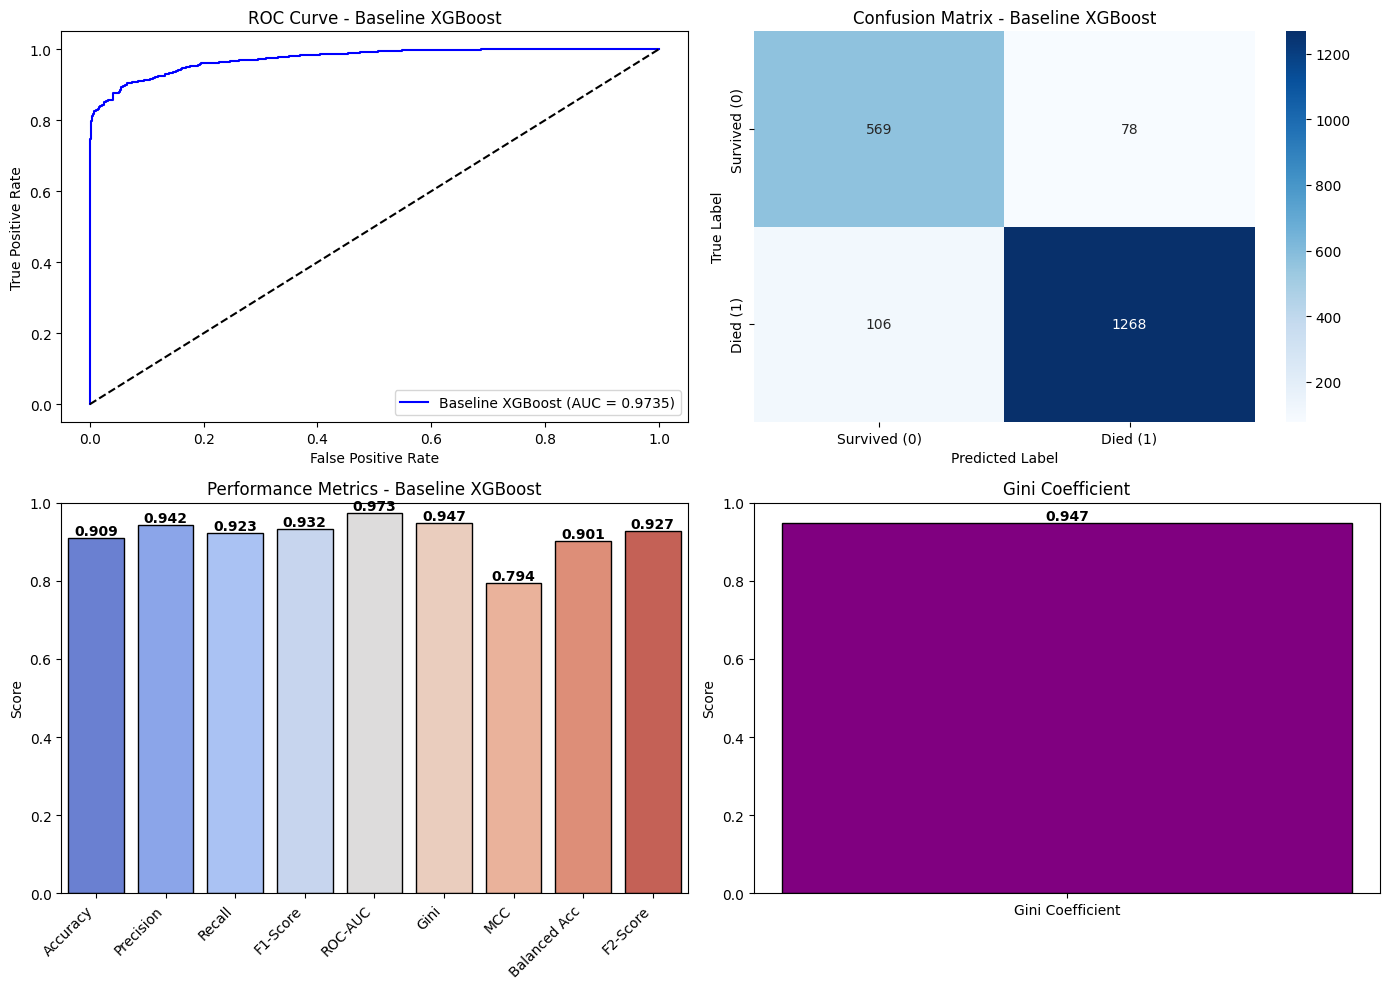

Evaluation plot saved to: ../visualizations\xgb_baseline_xgboost_evaluation.png


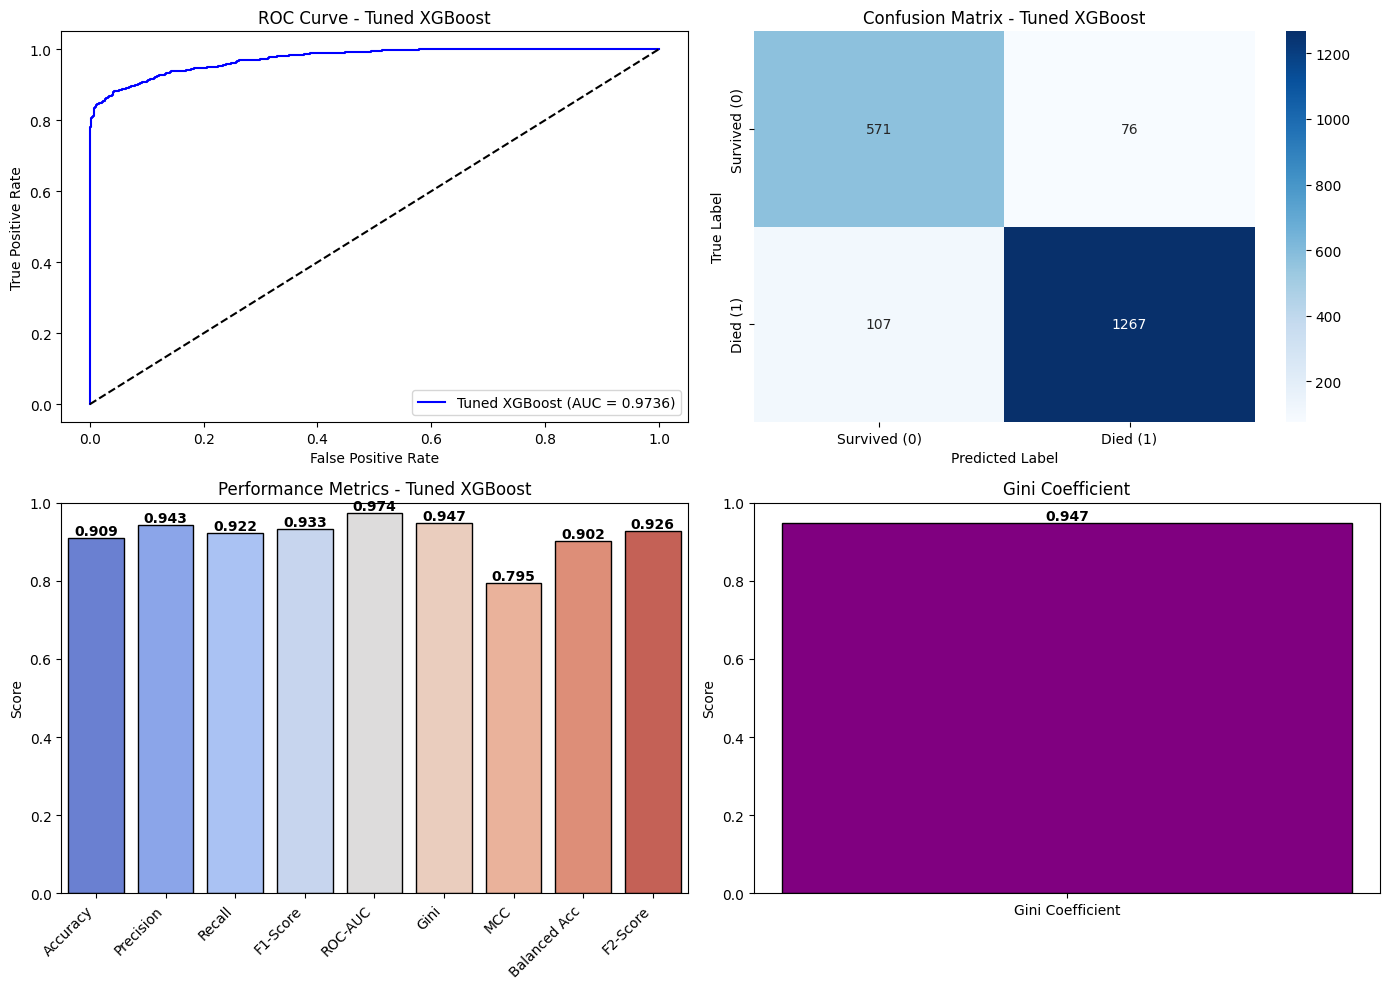

Evaluation plot saved to: ../visualizations\xgb_tuned_xgboost_evaluation.png

=== XGBoost Model Performance Summary ===
                  Accuracy  Precision    Recall  F1-Score   ROC-AUC      Gini  \
Tuned XGBoost     0.909451   0.943410  0.922125  0.932646  0.973570  0.947139   
Baseline XGBoost  0.908956   0.942051  0.922853  0.932353  0.973488  0.946975   

                       MCC  Balanced Accuracy  F2-Score  
Tuned XGBoost     0.795069           0.902330  0.926305  
Baseline XGBoost  0.793608           0.901148  0.926630  


In [42]:
# Evaluate & plot XGBoost models
evaluate_and_plot_model_extended(
    results_xgb,  # dictionary with the 2 XGB models
    y_test_clean, 
    output_dir="../visualizations", 
    prefix="xgb"
)

# Summarize in a DataFrame
xgb_performance_summary = pd.DataFrame.from_dict(
    results_xgb,
    orient="index",
    columns=[
        "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini",
        "MCC", "Balanced Accuracy", "F2-Score", "Confusion Matrix", "Predicted Probabilities"
    ]
)

# Drop unneeded columns and sort by ROC-AUC
xgb_performance_summary.drop(["Confusion Matrix", "Predicted Probabilities"], axis=1, inplace=True)
xgb_performance_summary.sort_values(by="ROC-AUC", ascending=False, inplace=True)

print("\n=== XGBoost Model Performance Summary ===")
print(xgb_performance_summary)


In [43]:
# Suppose you have results_logit from logistic, results_rf from random forest
# Combine them into a single dictionary
results_all = {}
results_all.update(results_logit)  # your existing logit results
results_all.update(results_rf)      # from Random Forest
results_all.update(results_xgb)     # from XGBoost

# # Plot all models together
# evaluate_and_plot_model_extended(
#     results_all, 
#     y_test_clean, 
#     output_dir="../visualizations", 
#     prefix="all_models"
# )

# Single summary DataFrame
performance_summary_all = pd.DataFrame.from_dict(
    results_all, 
    orient="index",
    columns=[
        "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini",
        "MCC", "Balanced Accuracy", "F2-Score", "Confusion Matrix", "Predicted Probabilities"
    ]
)
performance_summary_all.drop(["Confusion Matrix", "Predicted Probabilities"], axis=1, inplace=True)
performance_summary_all.sort_values(by="ROC-AUC", ascending=False, inplace=True)

print("\n=== Combined Model Performance Summary ===")
print(performance_summary_all)



=== Combined Model Performance Summary ===
                               Accuracy  Precision    Recall  F1-Score  \
Tuned Random Forest            0.915883   0.938776  0.937409  0.938092   
Baseline Random Forest         0.916873   0.941435  0.935953  0.938686   
Tuned XGBoost                  0.909451   0.943410  0.922125  0.932646   
Baseline XGBoost               0.908956   0.942051  0.922853  0.932353   
Base Logistic Regression       0.804552   0.851905  0.862445  0.857143   
Balanced Logistic Regression   0.792677   0.933697  0.748180  0.830707   
Best Tuned Model (GridSearch)  0.795646   0.921122  0.764920  0.835785   
SMOTE Logistic Regression      0.796141   0.924162  0.762737  0.835726   

                                ROC-AUC      Gini       MCC  \
Tuned Random Forest            0.976314  0.952628  0.806921   
Baseline Random Forest         0.974898  0.949796  0.809691   
Tuned XGBoost                  0.973570  0.947139  0.795069   
Baseline XGBoost               0.9734

## XGBOOST LITE

In [ ]:
#%pip install lightgbm


In [48]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix

# Dictionary to store LightGBM results
results_lgb_lite = {}

# A simple LightGBM classifier
lgb_lite = lgb.LGBMClassifier(
    random_state=420,
    is_unbalance=True
)

lgb_lite.fit(X_train_clean_tree, y_train_clean)

# Evaluate with your extended metrics function
lgb_lite_eval = evaluate_model_extended(
    lgb_lite,
    X_test_clean_tree,
    y_test_clean,
    model_name="LightGBM Lite"
)

# The function returns:
# (accuracy, precision, recall, f1, f2, roc_auc, gini, mcc, balanced_acc, y_pred_prob)
acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob = lgb_lite_eval

# Derive confusion matrix by thresholding the probabilities at 0.5
y_pred = (y_prob >= 0.5).astype(int)
cm_lite = confusion_matrix(y_test_clean, y_pred)

# Store in the same format as your logistic regression or other models:
# (acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm, y_prob)
results_lgb_lite["LightGBM Lite"] = (
    acc,
    prec,
    rec,
    f1,
    roc_auc,
    gini,
    mcc,
    bal_acc,
    f2,
    cm_lite,
    y_prob
)


[LightGBM] [Info] Number of positive: 5498, number of negative: 2586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8984
[LightGBM] [Info] Number of data points in the train set: 8084, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.680109 -> initscore=0.754272
[LightGBM] [Info] Start training from score 0.754272

=== LightGBM Lite Performance ===
Accuracy:         0.912
Precision:        0.944
Recall:           0.926
F1-Score:         0.935
F2-Score:         0.930
ROC-AUC:          0.9750
Gini Coefficient: 0.9500
MCC:              0.8012
Balanced Accuracy: 0.9045


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Dictionary to store LightGBM results
results_lgb_tuned = {}

# Define a parameter grid for LightGBM
lgb_param_grid = {
    "num_leaves": [31, 64],
    "max_depth": [5, 10, -1],    # -1 means "no limit"
    "learning_rate": [0.01, 0.1],
    "n_estimators": [100, 200]
    # Add more if you wish (min_child_samples, subsample, colsample_bytree, reg_alpha, etc.)
}

# Create a LightGBM classifier (baseline)
lgb_estimator = lgb.LGBMClassifier(
    random_state=420,
    is_unbalance=True #or class_weight="balanced"
)

# Use label-encoded data (X_train_clean_tree, X_test_clean_tree)
# or target-encoded data (X_train_clean_mean, X_test_clean_mean)

X_train_lgb = X_train_clean_tree
X_test_lgb = X_test_clean_tree

# Create a GridSearchCV object
lgb_gridsearch = GridSearchCV(
    estimator=lgb_estimator,
    param_grid=lgb_param_grid,
    scoring="roc_auc",   # Or "f1", "accuracy", "balanced_accuracy", etc.
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on the training set
lgb_gridsearch.fit(X_train_lgb, y_train_clean)

# Extract the best estimator
best_lgb = lgb_gridsearch.best_estimator_
print("\n=== Best Hyperparameters for LightGBM ===")
print(lgb_gridsearch.best_params_)

# Evaluate the tuned LightGBM model with extended metrics
lgb_tuned_eval = evaluate_model_extended(
    best_lgb,
    X_test_lgb,
    y_test_clean,
    model_name="Tuned LightGBM"
)

# The function returns:
# (accuracy, precision, recall, f1, f2, roc_auc, gini, mcc, bal_acc, y_pred_prob)
acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob = lgb_tuned_eval

# Derive confusion matrix by thresholding probabilities at 0.5
y_pred = (y_prob >= 0.5).astype(int)
cm_tuned = confusion_matrix(y_test_clean, y_pred)

# Store the results in the same format as logistic or other model dictionaries:
# (acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm, y_prob)
results_lgb_tuned["Tuned LightGBM"] = (
    acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm_tuned, y_prob
)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 5498, number of negative: 2586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8984
[LightGBM] [Info] Number of data points in the train set: 8084, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.680109 -> initscore=0.754272
[LightGBM] [Info] Start training from score 0.754272

=== Best Hyperparameters for LightGBM ===
{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 64}

=== Tuned LightGBM Performance ===
Accuracy:         0.916
Precision:        0.957
Recall:           0.918
F1-Score:         0.937
F2-Score:         0.925
ROC-AUC:          0.9761
Gini Coefficient: 0.9521
MCC:              0.8127
Balanced Accuracy: 0.9148


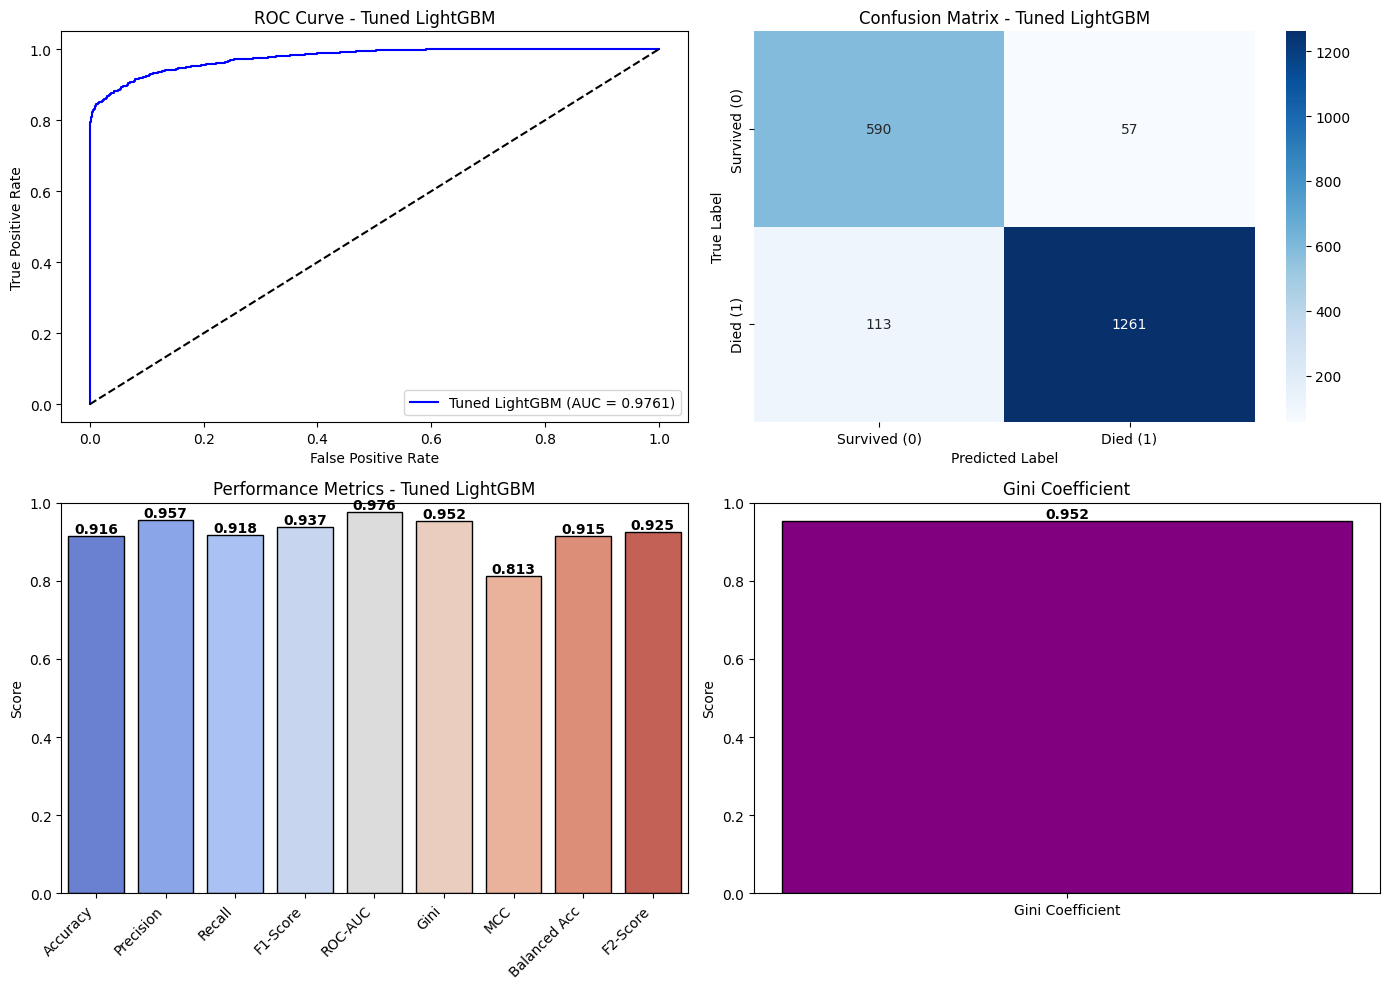

Evaluation plot saved to: ../visualizations\lgb_tuned_tuned_lightgbm_evaluation.png

=== Tuned LightGBM Performance Summary ===
                Accuracy  Precision    Recall  F1-Score   ROC-AUC      Gini  \
Tuned LightGBM  0.915883   0.956753  0.917758   0.93685  0.976051  0.952102   

                     MCC  Balanced Accuracy  F2-Score  
Tuned LightGBM  0.812662            0.91483  0.925301  


In [70]:
# 2A) Plot
evaluate_and_plot_model_extended(
    results_lgb_tuned,
    y_test_clean,
    output_dir="../visualizations",
    prefix="lgb_tuned"
)

# 2B) Summarize in a DataFrame
import pandas as pd

lgb_tuned_summary = pd.DataFrame.from_dict(
    results_lgb_tuned,
    orient="index",
    columns=[
        "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini",
        "MCC", "Balanced Accuracy", "F2-Score", "Confusion Matrix", "Predicted Probabilities"
    ]
)
lgb_tuned_summary.drop(["Confusion Matrix", "Predicted Probabilities"], axis=1, inplace=True)
lgb_tuned_summary.sort_values(by="ROC-AUC", ascending=False, inplace=True)

print("\n=== Tuned LightGBM Performance Summary ===")
print(lgb_tuned_summary)


In [53]:
results_all.update(results_logit)   # your logistic models
results_all.update(results_lgb_tuned)

performance_summary_all = pd.DataFrame.from_dict(
    results_all, 
    orient="index",
    columns=[
        "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini",
        "MCC", "Balanced Accuracy", "F2-Score", "Confusion Matrix", "Predicted Probabilities"
    ]
)
performance_summary_all.drop(["Confusion Matrix", "Predicted Probabilities"], axis=1, inplace=True)
performance_summary_all.sort_values(by="ROC-AUC", ascending=False, inplace=True)

print("\n=== Combined Model Performance Summary ===")
print(performance_summary_all)



=== Combined Model Performance Summary ===
                               Accuracy  Precision    Recall  F1-Score  \
Tuned Random Forest            0.915883   0.938776  0.937409  0.938092   
Tuned LightGBM                 0.913904   0.943787  0.928675  0.936170   
Baseline Random Forest         0.916873   0.941435  0.935953  0.938686   
Tuned XGBoost                  0.909451   0.943410  0.922125  0.932646   
Baseline XGBoost               0.908956   0.942051  0.922853  0.932353   
Base Logistic Regression       0.804552   0.851905  0.862445  0.857143   
Balanced Logistic Regression   0.792677   0.933697  0.748180  0.830707   
Best Tuned Model (GridSearch)  0.795646   0.921122  0.764920  0.835785   
SMOTE Logistic Regression      0.796141   0.924162  0.762737  0.835726   

                                ROC-AUC      Gini       MCC  \
Tuned Random Forest            0.976314  0.952628  0.806921   
Tuned LightGBM                 0.975471  0.950941  0.804225   
Baseline Random Forest    

## NEURAL NETWORK

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

# Dictionary to store NN results
results_nn = {}

# 1. Baseline MLP Pipeline
nn_baseline_pipeline = Pipeline([
    ("preprocessor", ct_clean_logit_nn),  # Does scaling, OHE, target encoding
    ("mlp", MLPClassifier(random_state=420, max_iter=1000))
])

# Fit the pipeline on your clean data (with missing values already handled)
nn_baseline_pipeline.fit(X_train_clean, y_train_clean)

# Evaluate using extended metrics
nn_baseline_eval = evaluate_model_extended(
    nn_baseline_pipeline,
    X_test_clean,
    y_test_clean,
    model_name="Baseline NN"
)

# nn_baseline_eval: (accuracy, precision, recall, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob)
acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob = nn_baseline_eval

# Confusion matrix at 0.5 threshold
y_pred = (y_prob >= 0.5).astype(int)
cm_baseline = confusion_matrix(y_test_clean, y_pred)

# Store in your results dict
# Format: (acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm, y_prob)
results_nn["Baseline NN"] = (
    acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm_baseline, y_prob
)



=== Baseline NN Performance ===
Accuracy:         0.789
Precision:        0.841
Recall:           0.852
F1-Score:         0.846
F2-Score:         0.849
ROC-AUC:          0.8693
Gini Coefficient: 0.7386
MCC:              0.5123
Balanced Accuracy: 0.7542


In [56]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
nn_param_grid = {
    "mlp__hidden_layer_sizes": [(64,), (64, 32), (128,)],
    "mlp__alpha": [0.0001, 0.001, 0.01],
    "mlp__learning_rate_init": [0.001, 0.01],
    # You could also tune "mlp__activation": ["relu", "tanh"] if you want
}

# Reuse the same pipeline but we'll call it nn_tune_pipeline
nn_tune_pipeline = Pipeline([
    ("preprocessor", ct_clean_logit_nn), 
    ("mlp", MLPClassifier(random_state=42, max_iter=1000))
])

nn_gridsearch = GridSearchCV(
    estimator=nn_tune_pipeline,
    param_grid=nn_param_grid,
    scoring="roc_auc",  # or "f1", "balanced_accuracy", etc.
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
nn_gridsearch.fit(X_train_clean, y_train_clean)

best_nn_model = nn_gridsearch.best_estimator_
print("\n=== Best Hyperparameters for MLP ===")
print(nn_gridsearch.best_params_)

# Evaluate the tuned NN model
nn_tuned_eval = evaluate_model_extended(
    best_nn_model,
    X_test_clean,
    y_test_clean,
    model_name="Tuned NN"
)

# Extract extended metrics
acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob = nn_tuned_eval
y_pred = (y_prob >= 0.5).astype(int)
cm_tuned = confusion_matrix(y_test_clean, y_pred)

results_nn["Tuned NN"] = (
    acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm_tuned, y_prob
)


Fitting 5 folds for each of 18 candidates, totalling 90 fits

=== Best Hyperparameters for MLP ===
{'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (128,), 'mlp__learning_rate_init': 0.001}

=== Tuned NN Performance ===
Accuracy:         0.778
Precision:        0.835
Recall:           0.840
F1-Score:         0.837
F2-Score:         0.839
ROC-AUC:          0.8670
Gini Coefficient: 0.7339
MCC:              0.4891
Balanced Accuracy: 0.7437


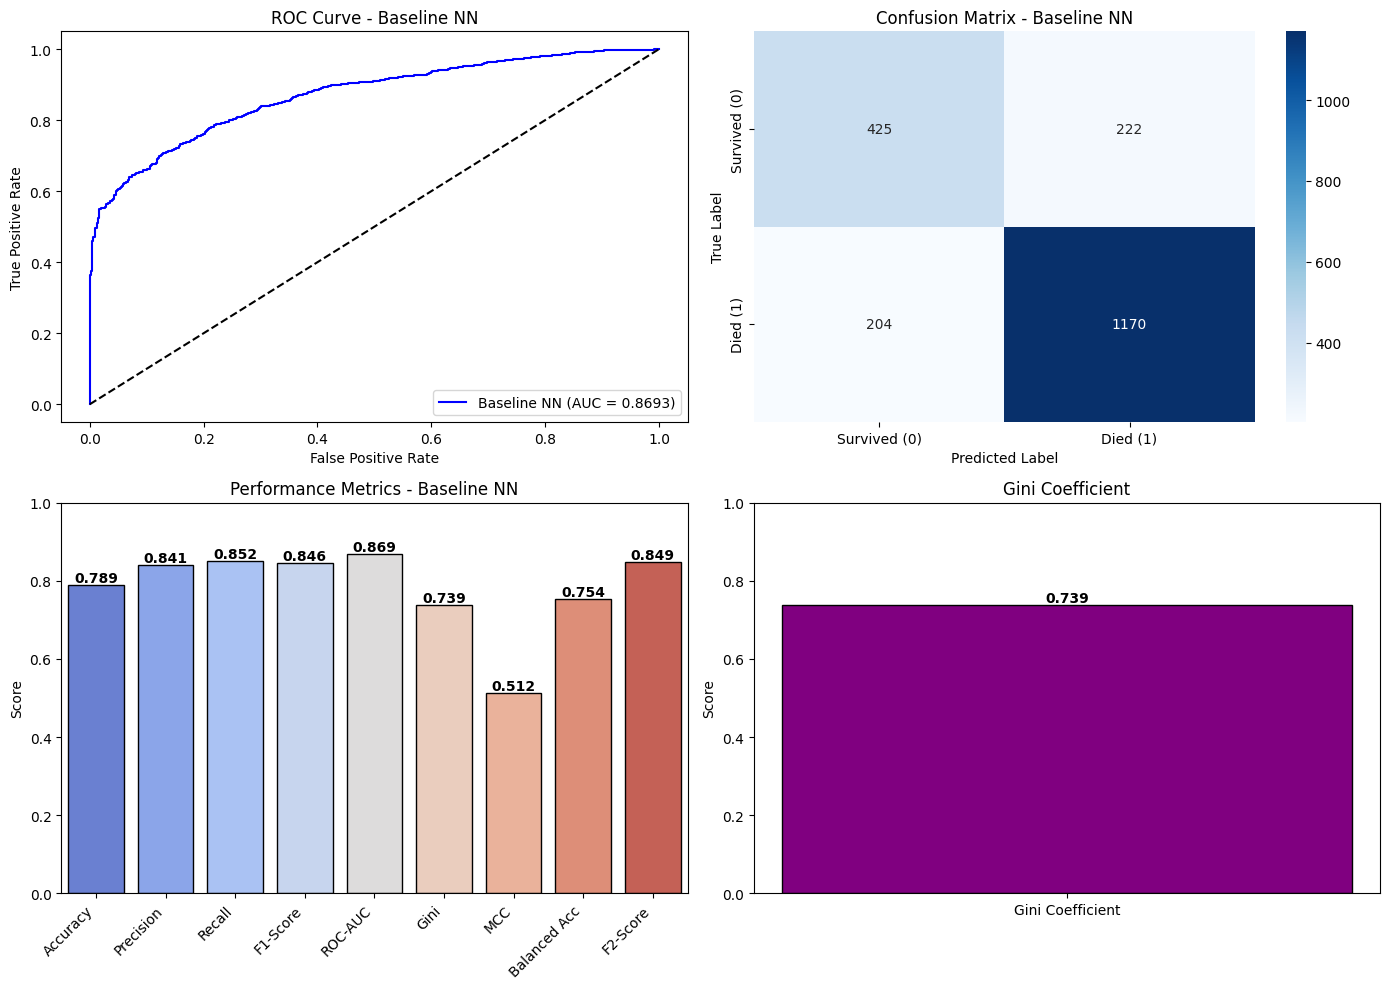

Evaluation plot saved to: ../visualizations\nn_baseline_nn_evaluation.png


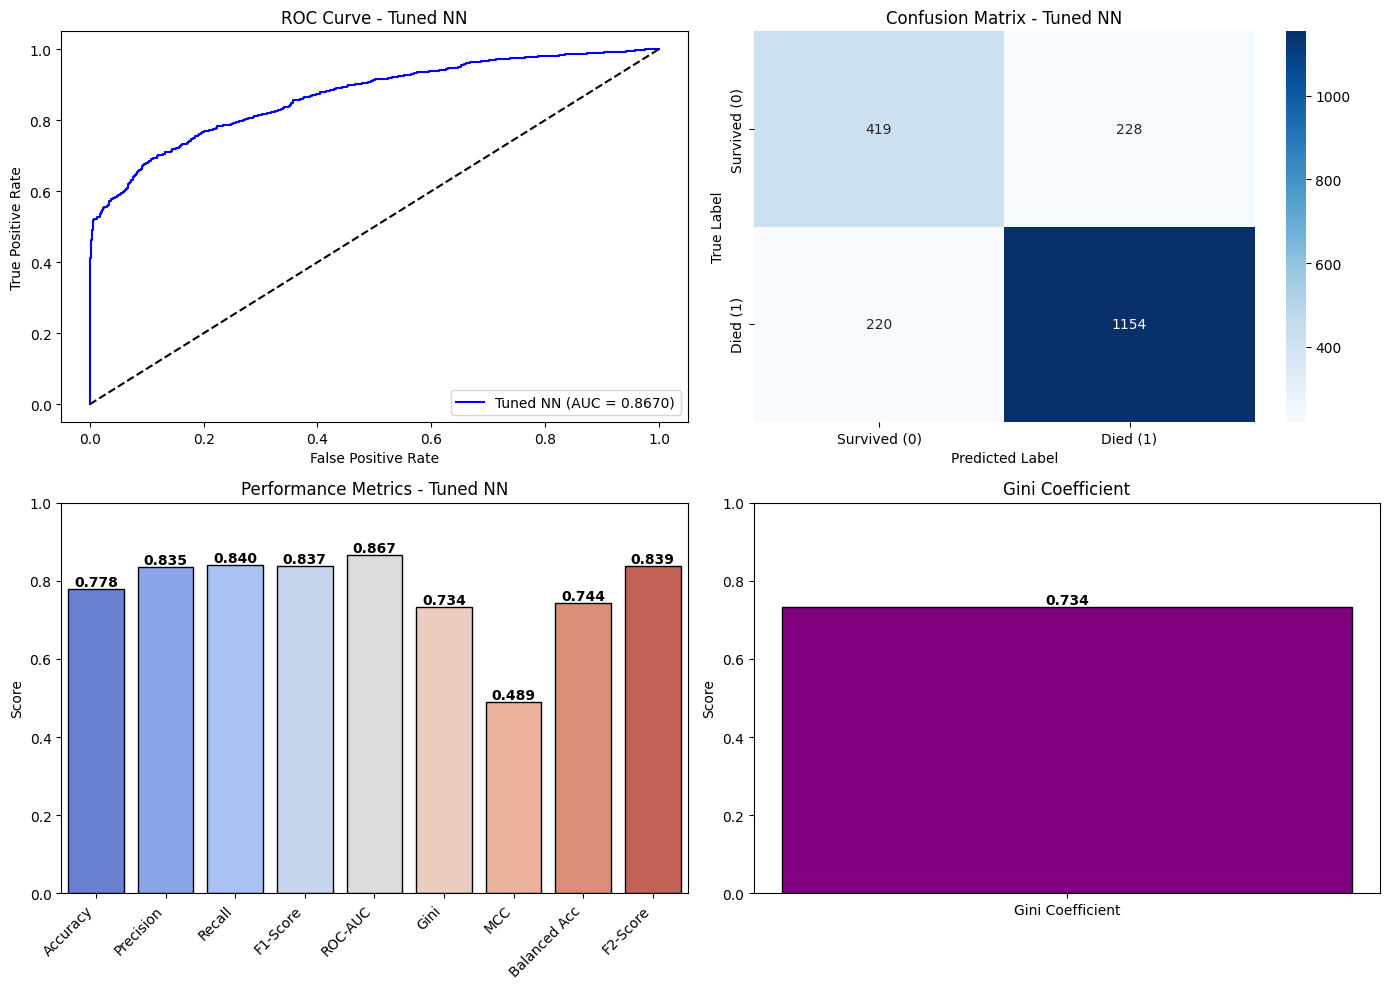

Evaluation plot saved to: ../visualizations\nn_tuned_nn_evaluation.png


In [57]:
evaluate_and_plot_model_extended(
    results_nn,        # dictionary containing both baseline & tuned NN
    y_test_clean,
    output_dir="../visualizations",
    prefix="nn"
)


In [58]:
import pandas as pd

nn_performance_summary = pd.DataFrame.from_dict(
    results_nn,
    orient="index",
    columns=[
        "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini",
        "MCC", "Balanced Accuracy", "F2-Score", "Confusion Matrix", "Predicted Probabilities"
    ]
)

# Drop confusion/prob columns
nn_performance_summary.drop(["Confusion Matrix", "Predicted Probabilities"], axis=1, inplace=True)
nn_performance_summary.sort_values(by="ROC-AUC", ascending=False, inplace=True)

print("\n=== Neural Network (MLP) Performance Summary ===")
print(nn_performance_summary)



=== Neural Network (MLP) Performance Summary ===
             Accuracy  Precision    Recall  F1-Score   ROC-AUC      Gini  \
Baseline NN  0.789213   0.840517  0.851528  0.845987  0.869293  0.738585   
Tuned NN     0.778328   0.835022  0.839884  0.837446  0.866969  0.733937   

                  MCC  Balanced Accuracy  F2-Score  
Baseline NN  0.512285           0.754203  0.849303  
Tuned NN     0.489108           0.743744  0.838907  


In [76]:
results_all = {}
results_all.update(results_logit)  # e.g. your logistic dict
results_all.update(results_rf)     # your random forest
results_all.update(results_xgb)    # your xgboost
results_all.update(results_nn)     # now add the NN

# evaluate_and_plot_model_extended(
#     results_all,
#     y_test_clean,
#     output_dir="../visualizations",
#     prefix="all_models"
# )

performance_summary_all = pd.DataFrame.from_dict(
    results_all,
    orient="index",
    columns=[
        "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini",
        "MCC", "Balanced Accuracy", "F2-Score", "Confusion Matrix", "Predicted Probabilities"
    ]
)
performance_summary_all.drop(["Confusion Matrix", "Predicted Probabilities"], axis=1, inplace=True)
performance_summary_all.sort_values(by="ROC-AUC", ascending=False, inplace=True)

print("\n=== Combined Model Performance Summary (Logit, RF, XGB, NN) ===")
print(performance_summary_all)



=== Combined Model Performance Summary (Logit, RF, XGB, NN) ===
                               Accuracy  Precision    Recall  F1-Score  \
Tuned Random Forest            0.915883   0.938776  0.937409  0.938092   
Baseline Random Forest         0.916873   0.941435  0.935953  0.938686   
Tuned XGBoost                  0.909451   0.943410  0.922125  0.932646   
Baseline XGBoost               0.908956   0.942051  0.922853  0.932353   
Base Logistic Regression       0.804552   0.851905  0.862445  0.857143   
Balanced Logistic Regression   0.792677   0.933697  0.748180  0.830707   
Best Tuned Model (GridSearch)  0.795646   0.921122  0.764920  0.835785   
SMOTE Logistic Regression      0.796141   0.924162  0.762737  0.835726   
Baseline NN                    0.789213   0.840517  0.851528  0.845987   
Tuned NN                       0.778328   0.835022  0.839884  0.837446   

                                ROC-AUC      Gini       MCC  \
Tuned Random Forest            0.976314  0.952628  0.8069

## Ensembling

In [72]:
logit_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scale_num', StandardScaler(),
                                                  ['adlsc', 'age', 'aps',
                                                   'avtisst', 'charges',
                                                   'dementia', 'diabetes',
                                                   'dnrday', 'feat01', 'feat02',
                                                   'feat03', 'feat04', 'feat05',
                                                   'feat06', 'feat07', 'feat08',
                                                   'feat09', 'feat10', 'hday',
                                                   'hospdead', 'hrt', 'meanbp',
                                                   'num.co', 'pafi', 'ph',
                                                   'prg2m', 'prg6m', 'resp',
                                                   'sod', 'sps', ...])...
                                                  ['sex', 'sfdm2_imputed',
                                                   'income', 'edu_category',
                                                   'dnr', 'alb_category', 'ca',
                                                   'race', 'bili_category',
                                                   'bun_category',
                                                   'glucose_category',
                                                   'scoma_category', 'dzclass',
                                                   'edu_bins']),
                                                 ('target_cat',
                                                  TargetEncoder(cols=['dzgroup',
                                                                      'age_group',
                                                                      'crea_category']),
                                                  ['dzgroup', 'age_group',
                                                   'crea_category'])])),
                ('logreg',
                 LogisticRegression(max_iter=1000, random_state=420))])

In [ ]:
nn_tune_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scale_num', StandardScaler(),
                                                  ['adlsc', 'age', 'aps',
                                                   'avtisst', 'charges',
                                                   'dementia', 'diabetes',
                                                   'dnrday', 'feat01', 'feat02',
                                                   'feat03', 'feat04', 'feat05',
                                                   'feat06', 'feat07', 'feat08',
                                                   'feat09', 'feat10', 'hday',
                                                   'hospdead', 'hrt', 'meanbp',
                                                   'num.co', 'pafi', 'ph',
                                                   'prg2m', 'prg6m', 'resp',
                                                   'sod', 'sps', ...])...
                                                                handle_unknown='ignore'),
                                                  ['sex', 'sfdm2_imputed',
                                                   'income', 'edu_category',
                                                   'dnr', 'alb_category', 'ca',
                                                   'race', 'bili_category',
                                                   'bun_category',
                                                   'glucose_category',
                                                   'scoma_category', 'dzclass',
                                                   'edu_bins']),
                                                 ('target_cat',
                                                  TargetEncoder(cols=['dzgroup',
                                                                      'age_group',
                                                                      'crea_category']),
                                                  ['dzgroup', 'age_group',
                                                   'crea_category'])])),
                ('mlp', MLPClassifier(max_iter=1000, random_state=42))])


=== Voting Ensemble Performance ===
Accuracy:         0.794
Precision:        0.848
Recall:           0.849
F1-Score:         0.848
F2-Score:         0.848
ROC-AUC:          0.8897
Gini Coefficient: 0.7793
MCC:              0.5258
Balanced Accuracy: 0.7628


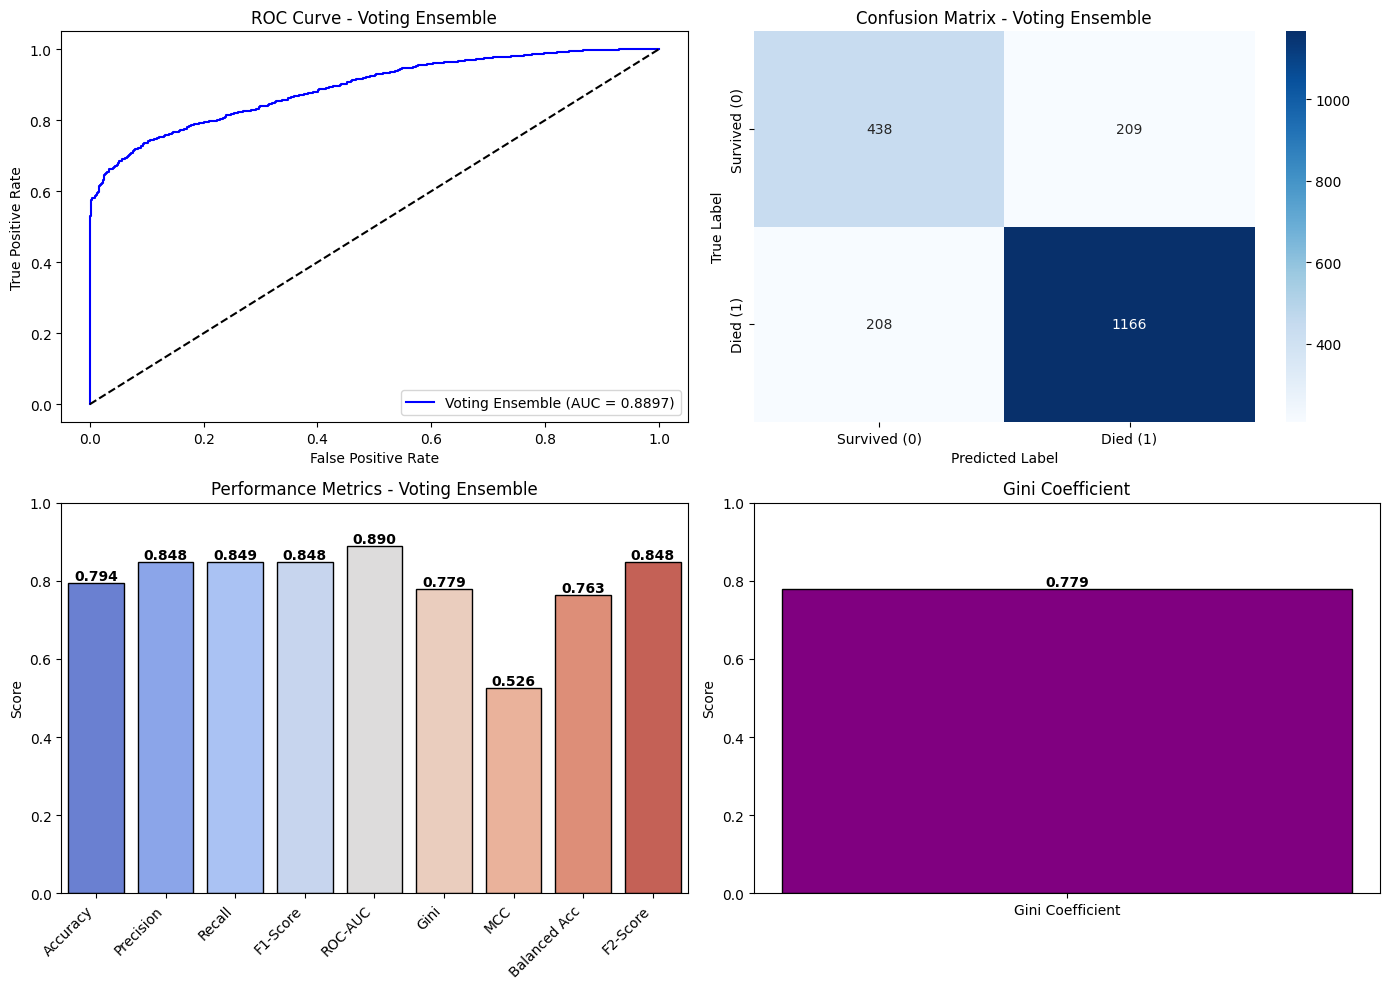

Evaluation plot saved to: ../visualizations\voting_ensemble_voting_ensemble_evaluation.png


In [ ]:
#################################
# 1) Voting / Stacking Ensemble #
#################################
from sklearn.ensemble import VotingClassifier
ensemble_results = {}

# Example: Voting over logistic + neural network, both sharing ct_clean_logit_nn
voting_ensemble = VotingClassifier(
    estimators=[
        ("logit", logit_pipeline),
        ("xgb", nn_tune_pipeline)
    ],
    voting="soft"
)
voting_ensemble.fit(X_train_clean, y_train_clean)

ens_eval = evaluate_model_extended(
    voting_ensemble,
    X_test_clean,
    y_test_clean,
    model_name="Voting Ensemble"
)
acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob = ens_eval
y_pred = (y_prob >= 0.5).astype(int)
cm_ens = confusion_matrix(y_test_clean, y_pred)

ensemble_results["Voting Ensemble"] = (
    acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm_ens, y_prob
)

evaluate_and_plot_model_extended(ensemble_results, y_test_clean, prefix="voting_ensemble")

In [60]:
from sklearn.ensemble import VotingClassifier

# Example:
# logit_pipeline -> uses ct_clean_logit_nn on X_train_clean
# rf_pipeline -> a pipeline that label-encodes or does the same transformations
# xgb_pipeline -> a pipeline that does target-encoding or consistent transformations

# Suppose we have:
#   - logit_pipeline_clean
#   - random_forest_pipeline
#   - xgb_pipeline
# each accepts X_train_clean as is.

voting_ensemble = VotingClassifier(
    estimators=[
        ("logit", logit_pipeline_clean),
        ("rf", random_forest_pipeline),
        ("xgb", xgb_pipeline)
    ],
    voting="soft"  # "soft" uses predicted probabilities
)

# Fit on the same clean dataset
voting_ensemble.fit(X_train_clean, y_train_clean)

# Evaluate with extended metrics
voting_results = {}
eval_result = evaluate_model_extended(
    voting_ensemble,
    X_test_clean,
    y_test_clean,
    model_name="Voting Ensemble"
)

# This returns (acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_pred_prob)
acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob = eval_result

from sklearn.metrics import confusion_matrix
y_pred = (y_prob >= 0.5).astype(int)
cm_ensemble = confusion_matrix(y_test_clean, y_pred)

voting_results["Voting Ensemble"] = (
    acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm_ensemble, y_prob
)

# Plot
evaluate_and_plot_model_extended(voting_results, y_test_clean, prefix="voting", output_dir="../visualizations")


NameError: name 'logit_pipeline_clean' is not defined

In [61]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stack_ensemble = StackingClassifier(
    estimators=[
        ("rf", random_forest_pipeline),
        ("xgb", xgb_pipeline),
        ("nn", nn_pipeline)
    ],
    final_estimator=LogisticRegression(),
    passthrough=False  # if True, meta-learner sees original features plus base predictions
)

stack_ensemble.fit(X_train_clean, y_train_clean)

# Evaluate as before
stack_results = {}
stack_eval = evaluate_model_extended(
    stack_ensemble,
    X_test_clean,
    y_test_clean,
    model_name="Stacking Ensemble"
)
acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob = stack_eval
cm_stack = confusion_matrix(y_test_clean, (y_prob >= 0.5).astype(int))

stack_results["Stacking Ensemble"] = (
    acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm_stack, y_prob
)


NameError: name 'random_forest_pipeline' is not defined

In [63]:
import numpy as np

feature_importances = rf_baseline.feature_importances_
feature_names = X_train_clean_tree.columns  # or however you track col names

# Sort by importance descending
sorted_idx = np.argsort(feature_importances)[::-1]
for idx in sorted_idx:
    print(f"{feature_names[idx]}: {feature_importances[idx]:.4f}")


glucose_imputed: 0.1922
sfdm2_imputed: 0.1012
hospdead: 0.0503
surv6m: 0.0323
bun_imputed: 0.0315
dnr: 0.0310
surv2m: 0.0266
dzgroup: 0.0240
bun_age_interaction: 0.0198
prg6m: 0.0194
dnrday: 0.0174
age: 0.0169
glucose_category: 0.0155
ca: 0.0147
dzclass: 0.0142
avtisst: 0.0140
charges: 0.0128
aps: 0.0121
sps: 0.0121
prg2m: 0.0119
hrt: 0.0117
totmcst: 0.0112
totcst: 0.0111
pafi: 0.0110
num.co: 0.0110
wblc: 0.0107
feat06: 0.0104
feat04: 0.0099
urine: 0.0099
feat10: 0.0099
feat01: 0.0098
meanbp: 0.0098
feat09: 0.0098
feat05: 0.0097
feat02: 0.0096
feat08: 0.0095
feat03: 0.0094
temp: 0.0089
feat07: 0.0089
crea_imputed: 0.0088
adls_imputed_adlsc: 0.0088
alb_imputed: 0.0087
resp: 0.0085
sod: 0.0082
adlsc: 0.0082
bun_category: 0.0077
adlp_imputed_adlsc: 0.0076
ph: 0.0075
bili_imputed: 0.0073
age_group: 0.0068
edu_imputed: 0.0065
num_co_binary: 0.0046
crea_category: 0.0042
scoma_sps_interaction: 0.0041
scoma_age_interaction: 0.0036
scoma_aps_interaction: 0.0035
hday: 0.0035
scoma_imputed: 0.002

In [64]:
model = xgb_baseline
importance = model.feature_importances_  # or model.get_booster().get_score(importance_type='weight')


# SHAP Explanations

In [65]:
import shap

# Suppose you have an XGBoost model 'best_xgb' trained on X_train_clean_mean
# X_test_clean_mean is your test set
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_clean_mean)

# Global importance
shap.summary_plot(shap_values, X_test_clean_mean, plot_type="bar")

# Detailed summary
shap.summary_plot(shap_values, X_test_clean_mean)

# One local explanation (for first test sample)
shap.force_plot(
    explainer.expected_value,
    shap_values[0,:],
    X_test_clean_mean.iloc[0,:]
)


NameError: name 'best_xgb' is not defined

In [66]:
# If pipeline is something like:
# Pipeline([("preprocessor", ct_clean_logit_nn), ("rf", RandomForestClassifier(...))])

preprocessed_X_test = pipeline["preprocessor"].transform(X_test_clean)  # numeric array
rf_model = pipeline["rf"]  # the fitted RF

import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(preprocessed_X_test)

shap.summary_plot(shap_values, preprocessed_X_test)


NameError: name 'pipeline' is not defined

In [77]:
#############################
# 3) SHAP for tuned XGBoost
#############################
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_clean_mean)

print("\nSHAP Summary Plot (Global) for XGBoost:")
shap.summary_plot(shap_values, X_test_clean_mean, plot_type="bar")

print("Detailed SHAP Summary Plot:")
shap.summary_plot(shap_values, X_test_clean_mean)

# Single sample local explanation
row_idx = 0
print(f"Local explanation for X_test_clean_mean row {row_idx}:")
shap.force_plot(
    explainer.expected_value,
    shap_values[row_idx, :],
    X_test_clean_mean.iloc[row_idx, :]
)

NameError: name 'xgb_model' is not defined

In [78]:
import numpy as np

# Check if X_train_clean_tree is a DataFrame; if it's a NumPy array, adapt accordingly
try:
    feature_names = X_train_clean_tree.columns  # if X_train_clean_tree is a DataFrame
except AttributeError:
    feature_names = [f"Feature_{i}" for i in range(X_train_clean_tree.shape[1])]

importances = best_rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

print("\n=== Random Forest Feature Importances (Top to Bottom) ===")
for idx in sorted_idx:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")



=== Random Forest Feature Importances (Top to Bottom) ===
glucose_imputed: 0.1911
sfdm2_imputed: 0.0978
hospdead: 0.0502
dnr: 0.0359
surv6m: 0.0327
bun_imputed: 0.0284
surv2m: 0.0239
dzgroup: 0.0237
prg6m: 0.0227
bun_age_interaction: 0.0207
glucose_category: 0.0203
ca: 0.0170
age: 0.0165
dnrday: 0.0157
avtisst: 0.0141
charges: 0.0136
dzclass: 0.0124
sps: 0.0123
totcst: 0.0121
aps: 0.0119
totmcst: 0.0113
hrt: 0.0112
pafi: 0.0111
wblc: 0.0110
prg2m: 0.0108
num.co: 0.0106
feat03: 0.0104
feat06: 0.0104
meanbp: 0.0101
feat01: 0.0100
feat08: 0.0098
feat02: 0.0098
feat04: 0.0098
feat09: 0.0098
urine: 0.0095
feat07: 0.0094
feat10: 0.0092
feat05: 0.0092
temp: 0.0088
crea_imputed: 0.0087
resp: 0.0083
adls_imputed_adlsc: 0.0083
sod: 0.0082
adlsc: 0.0082
alb_imputed: 0.0079
bun_category: 0.0075
ph: 0.0075
bili_imputed: 0.0073
adlp_imputed_adlsc: 0.0069
age_group: 0.0067
edu_imputed: 0.0060
num_co_binary: 0.0049
crea_category: 0.0043
scoma_sps_interaction: 0.0040
scoma_age_interaction: 0.0039
hday

In [80]:
results_models

NameError: name 'results_models' is not defined

In [79]:
# Evaluate & plot all models in results_models
evaluate_and_plot_model_extended(
    results_models,     # dict containing MLP and RF
    y_test_clean, 
    output_dir="../visualizations",
    prefix="mlp_rf"
)

# Summarize in a DataFrame
import pandas as pd

performance_summary = pd.DataFrame.from_dict(
    results_models,
    orient="index",
    columns=[
        "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini",
        "MCC", "Balanced Accuracy", "F2-Score", "Confusion Matrix", "Predicted Probabilities"
    ]
)

# Drop confusion/prob for clarity
performance_summary.drop(["Confusion Matrix", "Predicted Probabilities"], axis=1, inplace=True)
performance_summary.sort_values(by="ROC-AUC", ascending=False, inplace=True)

print("\n=== Performance Summary (MLP vs. Tuned RF) ===")
print(performance_summary)


NameError: name 'results_models' is not defined


=== Baseline MLP Performance ===
Accuracy:         0.789
Precision:        0.841
Recall:           0.852
F1-Score:         0.846
F2-Score:         0.849
ROC-AUC:          0.8693
Gini Coefficient: 0.7386
MCC:              0.5123
Balanced Accuracy: 0.7542
Fitting 5 folds for each of 72 candidates, totalling 360 fits

=== Best Hyperparameters for RandomForest ===
{'class_weight': None, 'max_depth': 20, 'n_estimators': 500}

=== Tuned Random Forest Performance ===
Accuracy:         0.916
Precision:        0.939
Recall:           0.937
F1-Score:         0.938
F2-Score:         0.938
ROC-AUC:          0.9763
Gini Coefficient: 0.9526
MCC:              0.8069
Balanced Accuracy: 0.9038

=== Random Forest Feature Importances ===
glucose_imputed: 0.1911
sfdm2_imputed: 0.0978
hospdead: 0.0502
dnr: 0.0359
surv6m: 0.0327
bun_imputed: 0.0284
surv2m: 0.0239
dzgroup: 0.0237
prg6m: 0.0227
bun_age_interaction: 0.0207
glucose_category: 0.0203
ca: 0.0170
age: 0.0165
dnrday: 0.0157
avtisst: 0.0141
charges:

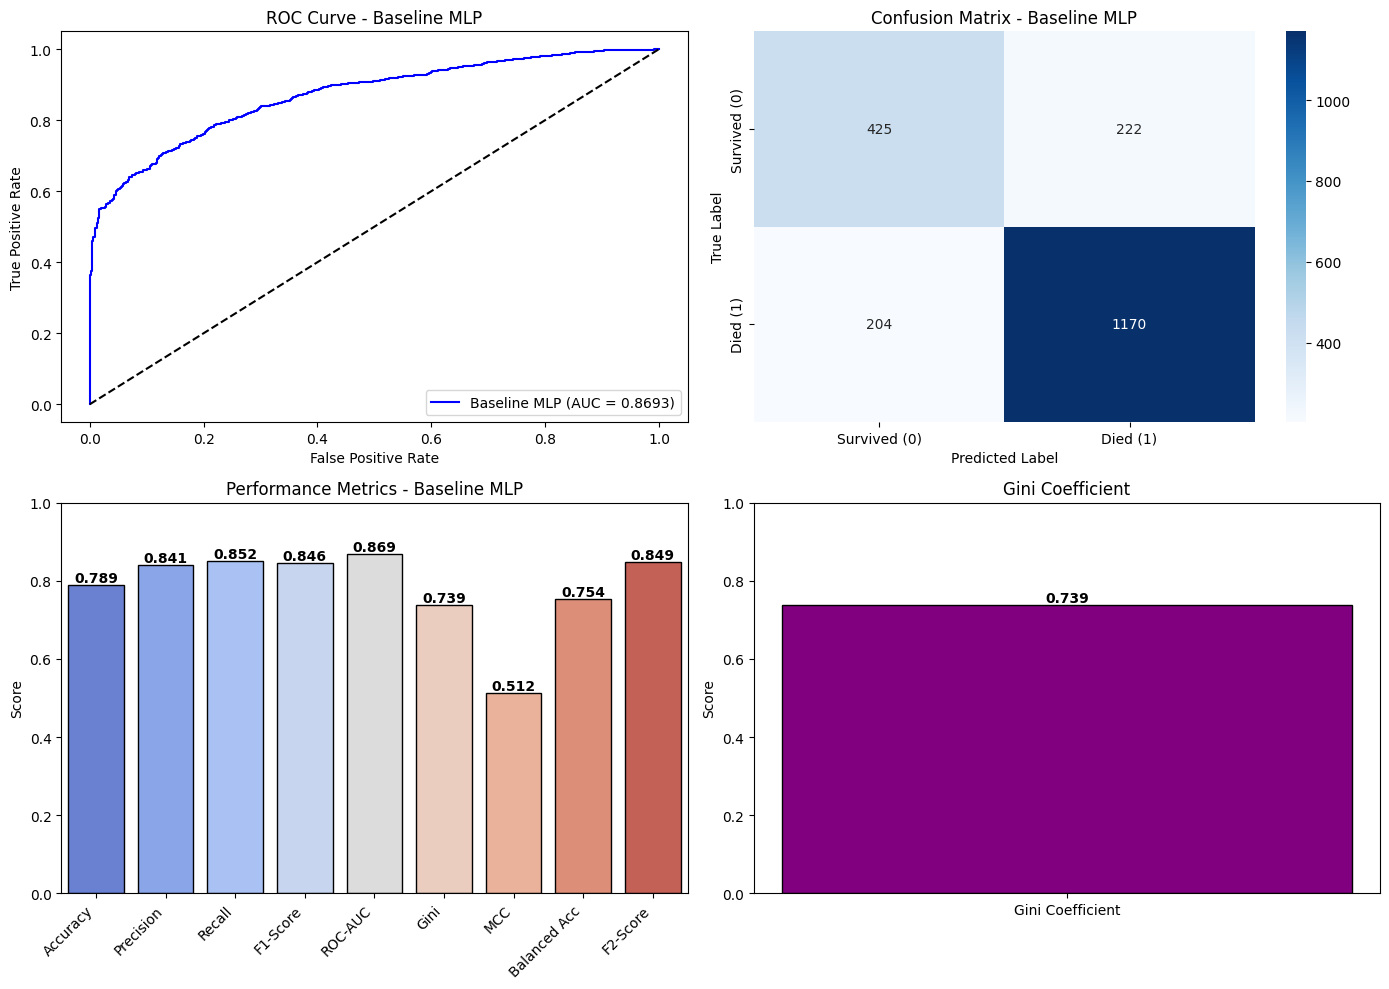

Evaluation plot saved to: ../visualizations\mlp_rf_baseline_mlp_evaluation.png


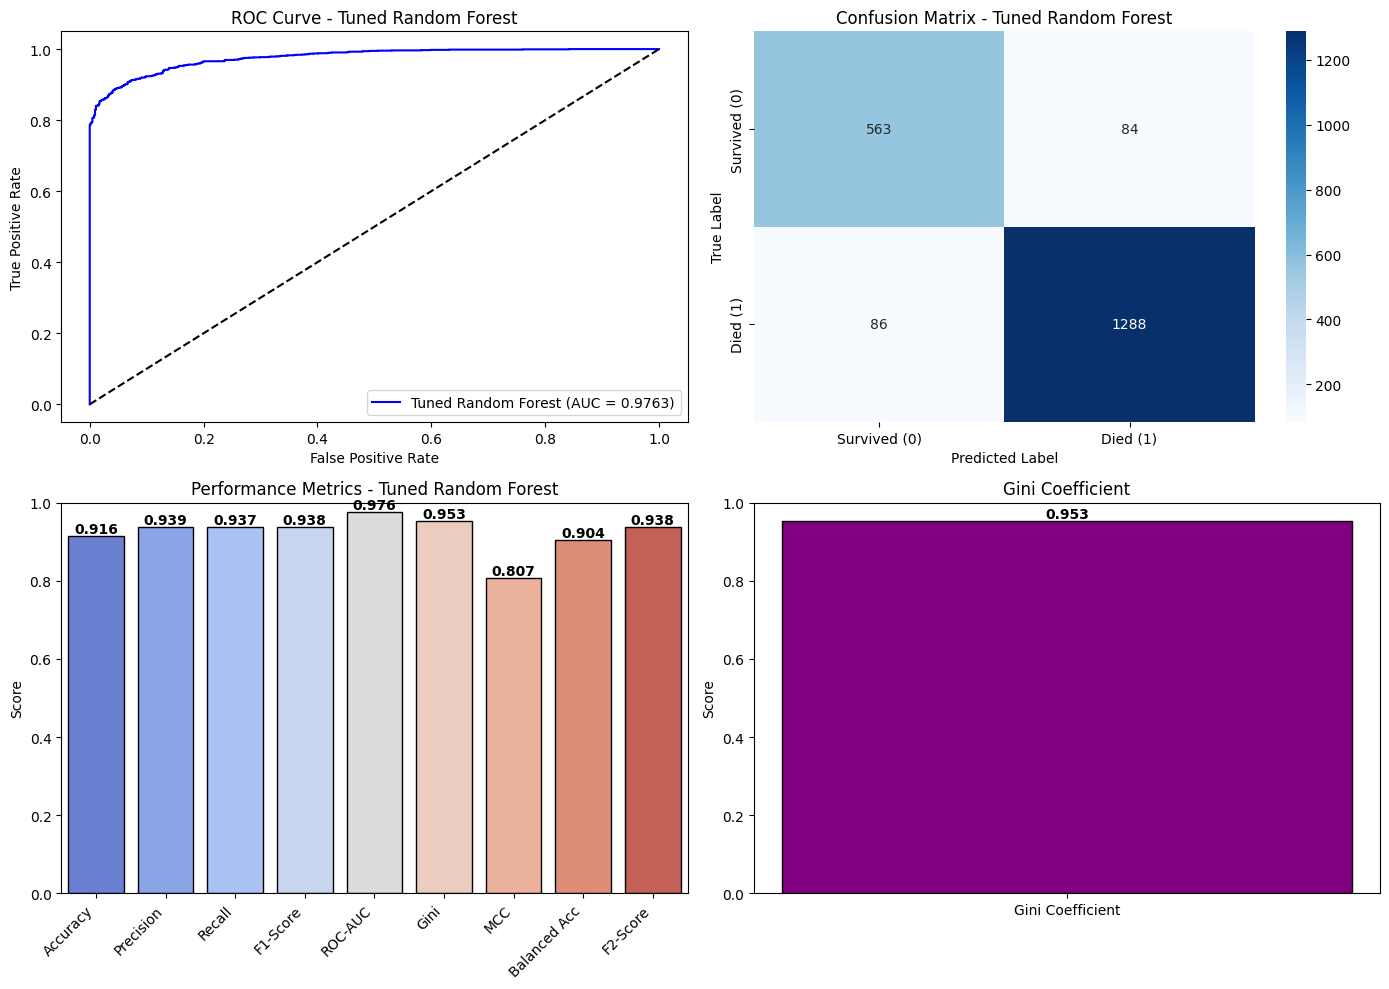

Evaluation plot saved to: ../visualizations\mlp_rf_tuned_random_forest_evaluation.png

=== Performance Summary (MLP vs. Tuned RF) ===
                     Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
Tuned Random Forest  0.915883   0.938776  0.937409  0.938092  0.976314   
Baseline MLP         0.789213   0.840517  0.851528  0.845987  0.869293   

                         Gini       MCC  Balanced Accuracy  F2-Score  
Tuned Random Forest  0.952628  0.806921           0.903790  0.937682  
Baseline MLP         0.738585  0.512285           0.754203  0.849303  


In [81]:
###########################################################
# Baseline MLP + Tuned RF (GridSearch), Feature Importance
###########################################################

# 1) Baseline MLP Pipeline
nn_baseline_pipeline = Pipeline([
    ("preprocessor", ct_clean_logit_nn),  # scaling, OHE, target encoding
    ("mlp", MLPClassifier(random_state=420, max_iter=1000))
])

nn_baseline_pipeline.fit(X_train_clean, y_train_clean)

results_models = {}

# Evaluate MLP
nn_baseline_eval = evaluate_model_extended(
    nn_baseline_pipeline,
    X_test_clean,
    y_test_clean,
    model_name="Baseline MLP"
)
acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob = nn_baseline_eval
from sklearn.metrics import confusion_matrix
cm_nn = confusion_matrix(y_test_clean, (y_prob >= 0.5).astype(int))

results_models["Baseline MLP"] = (
    acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm_nn, y_prob
)

# 2) Random Forest GridSearch
rf_param_grid = {
    "n_estimators": [100, 200, 300, 400, 500, 600],
    "max_depth": [None, 5, 10, 20, 30, 40],
    "class_weight": [None, "balanced"]
}

rf_gridsearch = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)
rf_gridsearch.fit(X_train_clean_tree, y_train_clean)

best_rf = rf_gridsearch.best_estimator_
print("\n=== Best Hyperparameters for RandomForest ===")
print(rf_gridsearch.best_params_)

# Evaluate Tuned RF
rf_tuned_eval = evaluate_model_extended(
    best_rf,
    X_test_clean_tree,
    y_test_clean,
    model_name="Tuned Random Forest"
)
acc, prec, rec, f1, f2, roc_auc, gini, mcc, bal_acc, y_prob = rf_tuned_eval
cm_rf = confusion_matrix(y_test_clean, (y_prob >= 0.5).astype(int))

results_models["Tuned Random Forest"] = (
    acc, prec, rec, f1, roc_auc, gini, mcc, bal_acc, f2, cm_rf, y_prob
)

# 3) Feature Importances for Best RF
import numpy as np
try:
    feature_names = X_train_clean_tree.columns
except AttributeError:
    feature_names = [f"Feature_{i}" for i in range(X_train_clean_tree.shape[1])]

importances = best_rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
print("\n=== Random Forest Feature Importances ===")
for idx in sorted_idx:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")

# 4) Visualize & Summarize
evaluate_and_plot_model_extended(
    results_models,
    y_test_clean,
    output_dir="../visualizations",
    prefix="mlp_rf"
)

import pandas as pd
performance_summary = pd.DataFrame.from_dict(
    results_models,
    orient="index",
    columns=[
        "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini",
        "MCC", "Balanced Accuracy", "F2-Score", "Confusion Matrix", "Predicted Probabilities"
    ]
)
performance_summary.drop(["Confusion Matrix", "Predicted Probabilities"], axis=1, inplace=True)
performance_summary.sort_values(by="ROC-AUC", ascending=False, inplace=True)

print("\n=== Performance Summary (MLP vs. Tuned RF) ===")
print(performance_summary)


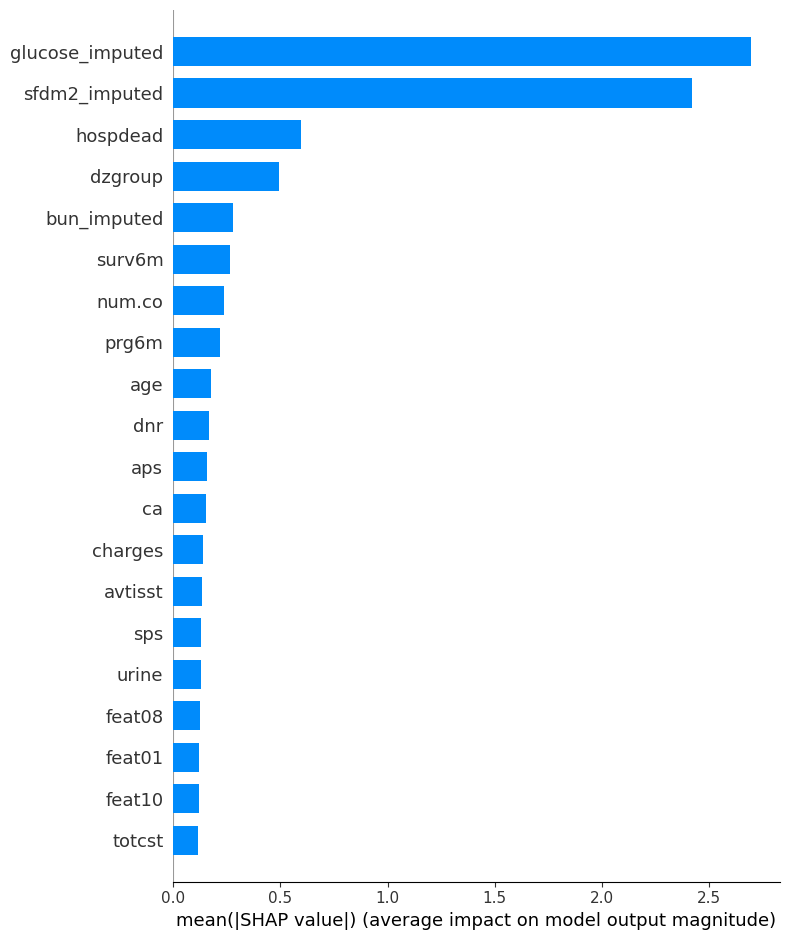

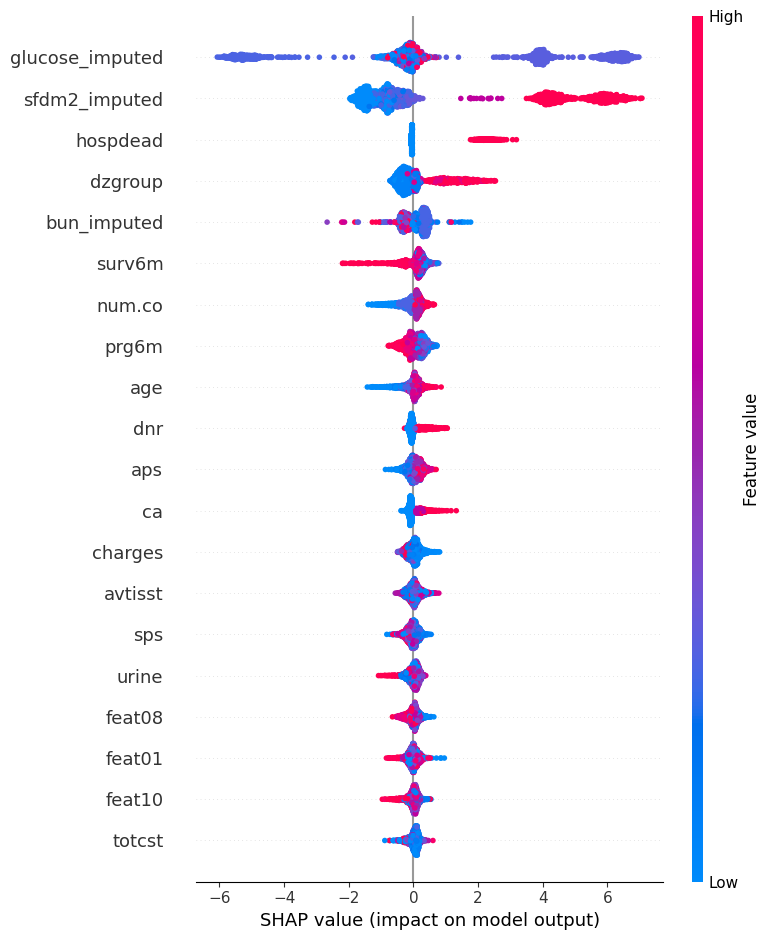

In [84]:
import shap

# Suppose xgb_baseline is your XGBoost model loaded from xgb_baseline.pkl
# and X_test_clean_mean is the DataFrame used for XGBoost’s predictions.
explainer = shap.TreeExplainer(xgb_baseline)
shap_values = explainer.shap_values(X_test_clean_mean)

# Global importance (bar chart)
shap.summary_plot(shap_values, X_test_clean_mean, plot_type="bar")

# Detailed beeswarm plot
shap.summary_plot(shap_values, X_test_clean_mean)

# One local explanation (for the first sample)
shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X_test_clean_mean.iloc[0, :]
)


In [ ]:
import os
import pickle
import joblib
import shap
import pandas as pd

# 1) Load XGBoost model & results
xgb_model_path = "../XGBOOST/xgb_baseline.pkl"
xgb_baseline = joblib.load(xgb_model_path)

results_xgb_path = "../XGBOOST/results_xgb.pkl"
with open(results_xgb_path, "rb") as f:
    results_xgb = pickle.load(f)

print("XGBoost model and results loaded successfully!")

# 2) Merge with other model results
# Suppose you have 'results_models' containing MLP & RF
results_all = {}
results_all.update(results_models)  # e.g. "Baseline MLP", "Tuned RF"
results_all.update(results_xgb)     # e.g. "Baseline XGBoost"

# 3) Evaluate & Plot all
evaluate_and_plot_model_extended(
    results_all,
    y_test_clean,
    output_dir="../visualizations",
    prefix="combined"
)

# 4) Combined summary table
performance_summary_all = pd.DataFrame.from_dict(
    results_all,
    orient="index",
    columns=[
        "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Gini",
        "MCC", "Balanced Accuracy", "F2-Score", "Confusion Matrix", "Predicted Probabilities"
    ]
)
performance_summary_all.drop(["Confusion Matrix", "Predicted Probabilities"], axis=1, inplace=True)
performance_summary_all.sort_values(by="ROC-AUC", ascending=False, inplace=True)
print("\n=== Combined Model Performance Summary ===")
print(performance_summary_all)

# 5) SHAP on loaded XGBoost
explainer = shap.TreeExplainer(xgb_baseline)
shap_values = explainer.shap_values(X_test_clean_mean)
shap.summary_plot(shap_values, X_test_clean_mean, plot_type="bar")
